Feature Engineering ใน Notebook นี้จัดทำขึ้นเพื่อ clean feature ทั้ง Numerical และ Categorical โดยมีทดลองจัดการกับ Value เหล่านี้ 2 แบบ
* แบบที่ 1 :
    * Categorical Feature : group ข้อมูลเป็นกลุ่มใหญ่ ๆ และตัด row ที่มี missing value ออก
    * Numerical : นำ Row ที่เป็น Outlier และ Missing Value ออก
* แบบที่ 2 :
    * Categorical Feature : group ข้อมูลเป็นกลุ่มใหญ่ ๆ และเติม Missing value ด้วย Mode
    * Numerical : เติม Missing value ด้วย median และ cap ค่า outlier

In [1]:
from src.clean_data import *
from src.exploratory_data_analysis import *
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_subplots(df ,df1, df2, df3, df4, column_name):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    
    dataframes = [df, df1, df2, df3, df4]
    titles = ["Raw Data", "Method 1", "Method 2", "Method 3", "Method 4"]
    
    for i, (df, title) in enumerate(zip(dataframes, titles)):
        if column_name not in df.columns:
            axes[i].set_title(f"{title} (No Data)")
            axes[i].axis("off")
            continue
        
        if pd.api.types.is_numeric_dtype(df[column_name]):
            sns.boxplot(y=df[column_name], ax=axes[i])
        else:
            sns.countplot(x=df[column_name], ax=axes[i], order=df[column_name].value_counts().index)
            axes[i].tick_params(axis='x', rotation=90)
        
        axes[i].set_title(title)
    
    fig.suptitle(column_name, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'./output/pic/{column_name}.jpg')
    plt.show()

In [3]:
def bin_numerical_columns(df, numerical_columns, threshold = 30, num_bin=3):
    df_copy = df.copy()  # สร้างสำเนาเพื่อไม่ให้แก้ไข DataFrame ต้นฉบับ
    
    for col in numerical_columns:
        col_range = df[col].max() - df[col].min()  # คำนวณช่วง (range)
        
        if col_range >= threshold:
            # คำนวณช่วงของ bin
            bins = np.linspace(df[col].min(), df[col].max(), num_bin + 1)
            
            # สร้าง labels สำหรับแต่ละ bin เช่น "5-10", "11-20"
            labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins) - 1)]
            
            # ทำ binning โดยใช้ labels แทนตัวเลข
            df_copy[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)

            df_copy[col] = df_copy[col].astype(str)
    
    return df_copy

In [4]:
def scale_data(data,scale_by='standard_scaler',target_col = 'มูลค่าความเสียหาย'):
    if scale_by == 'standard_scaler':
        # ใช้ StandardScaler
        scaler = StandardScaler()
    elif scale_by == 'min_max':
        scaler = MinMaxScaler()
        
    features = data.drop(target_col,axis=1)
    scaled_features = scaler.fit_transform(features)

    # สร้าง DataFrame ใหม่ที่สเกลแล้ว
    df_scaled = pd.DataFrame(scaled_features, columns=features.columns)

    # นำคอลัมน์ target กลับมา
    df_scaled[target_col] = data[target_col]
    return df_scaled

In [5]:
raw_data = pd.read_csv('./data/accident2024 + $Damage.csv')
target = 'มูลค่าความเสียหาย'
df = raw_data.copy()
df['รวมผู้ได้รับผลกระทบ'] = df[['จำนวนผู้เสียชีวิต', 'จำนวนผู้บาดเจ็บสาหัส', 'จำนวนผู้บาดเจ็บเล็ก']].sum(axis=1) 

In [6]:
# ระบุ column ที่เป็น categorical และ numerical
categorical_feature = ['บริเวณที่เกิดเหตุ', 'มูลเหตุสันนิษฐาน',
               'ลักษณะการเกิดอุบัติเ', 'สภาพอากาศ']
numerical_feature = ['รถจักรยานยนต์', 'รถสามล้อเครื่อง',
       'รถยนต์นั่งส่วนบุคคล', 'รถตู้', 'รถปิคอัพโดยสาร', 'รถโดยสารมากกว่า4ล้อ',
       'รถปิคอัพบรรทุก4ล้อ', 'รถบรรทุก6ล้อ', 'รถบรรทุกไม่เกิน10ล้อ',
       'รถบรรทุกมากกว่า10ล้อ', 'รถอีแต๋น', 'อื่นๆ', 'คนเดินเท้า',
       'จำนวนผู้เสียชีวิต', 'จำนวนผู้บาดเจ็บสาหัส', 'จำนวนผู้บาดเจ็บเล็ก',
       'รวมจำนวนผู้บาดเจ็บ']

columns_to_clean = [
    'จังหวัด', 'รถคันที่1', 'บริเวณที่เกิดเหตุ', 'มูลเหตุสันนิษฐาน', 'ลักษณะการเกิดอุบัติเ', 
    'สภาพอากาศ', 'จำนวนรถที่เกิดเหตุ', 'จำนวนที่เกิดเหตุทั้ง', 'รถจักรยานยนต์', 'รถสามล้อเครื่อง', 
    'รถยนต์นั่งส่วนบุคคล', 'รถตู้', 'รถปิคอัพโดยสาร', 'รถโดยสารมากกว่า4ล้อ', 'รถปิคอัพบรรทุก4ล้อ', 
    'รถบรรทุก6ล้อ', 'รถบรรทุกไม่เกิน10ล้อ', 'รถบรรทุกมากกว่า10ล้อ', 'รถอีแต๋น', 'อื่นๆ', 'คนเดินเท้า', 
    'จำนวนผู้เสียชีวิต', 'จำนวนผู้บาดเจ็บสาหัส', 'จำนวนผู้บาดเจ็บเล็ก', 'รวมจำนวนผู้บาดเจ็บ', 'มูลค่าความเสียหาย'
]

province_json_path = 'thailand_provinces.json'

# Clean แบบที่ 1
* Drop Missing value
* Bound Outlier

In [7]:
car_column = ['รถจักรยานยนต์', 'รถสามล้อเครื่อง', 'รถยนต์นั่งส่วนบุคคล', 'รถตู้',
        'รถปิคอัพโดยสาร', 'รถโดยสารมากกว่า4ล้อ', 'รถปิคอัพบรรทุก4ล้อ',
        'รถบรรทุก6ล้อ', 'รถบรรทุกไม่เกิน10ล้อ', 'รถบรรทุกมากกว่า10ล้อ',
        'รถอีแต๋น', 'อื่นๆ']

In [8]:
clean_1 = df.copy()

# Drop Missing Value
clean_1 = clean_1.dropna(subset = columns_to_clean)

# Bound Outlier
clean_1 = cap_outlier_alternative(clean_1,numerical_feature)

# Recalculate Summary Column
clean_1 = recalculate_accident_number(clean_1)

# Group Feature
clean_1 = group_categorical_feature(clean_1)

# Add ข้อมูล ภาค
clean_1 = add_region(clean_1)


clean_1.to_csv('./output/clean_method_1.csv',encoding='utf-8-sig')

In [9]:
to_delete = ['LATITUDE', 'LONGITUDE','จังหวัด', 'รถคันที่1', 'บริเวณที่เกิดเหตุ', 'มูลเหตุสันนิษฐาน',
             'ลักษณะการเกิดอุบัติเ', 'สภาพอากาศ']



In [10]:
clean_1[columns_to_clean].to_csv('for_slide.csv',index= False, encoding='utf-8-sig')

In [11]:
clean_1[columns_to_clean].isnull().sum().sum() == 0

True

# Clean แบบที่ 2
* Drop Missing value
* Bin Outlier

In [12]:
clean_2 = df.copy()

# Drop Missing Value
clean_2 = clean_2.dropna(subset = columns_to_clean)

# Recalculate Summary Column
clean_2 = recalculate_accident_number(clean_2)

# Bin Outlier
clean_2 = bin_numerical_columns(clean_2,numerical_feature)

# Group Feature
clean_2 = group_categorical_feature(clean_2)

# Add ข้อมูล ภาค
clean_2 = add_region(clean_2)

clean_2.to_csv('./output/clean_method_2.csv',encoding='utf-8-sig')

In [13]:
clean_2[columns_to_clean].isnull().sum().sum() == 0

True

# Clean แบบที่ 3
* Fill Missing Value
* Bound Outlier

In [ ]:
cleaned_3_df = df.copy()

# ---- เติม Numerical Variable ----
cleaned_3_df = fill_missing_with_median(cleaned_3_df,numerical_feature)

# ---- Clean Categorical -------
cleaned_3_df = fill_missing_with_mode(cleaned_3_df, categorical_feature) # เติมด้วย Mode

# เติมรถคันที่ 1
priority_list = df[car_column].sum().sort_values(ascending = False).index.tolist()

cleaned_3_df['รถคันที่1'] = cleaned_3_df.apply(fill_missing_vehicle, axis=1,priority_list=priority_list)
cleaned_3_df['รถคันที่1'] = cleaned_3_df['รถคันที่1'].fillna(cleaned_3_df['รถคันที่1'].iloc[0])
cleaned_3_df = group_categorical_feature(cleaned_3_df) # จัดกลุ่ม

# ปรับแก้ outlier
cleaned_3_df = cap_outlier_alternative(cleaned_3_df,numerical_feature)

# Recalculate
cleaned_3_df = recalculate_accident_number(cleaned_3_df)

# Clean ข้อมูลจังหวัด
cleaned_3_df = fill_province(cleaned_3_df,province_json_path)

# Add ข้อมูล ภาค
cleaned_3_df = add_region(cleaned_3_df)

cleaned_3_df.to_csv('./output/clean_method_3.csv',encoding='utf-8-sig')

In [17]:
cleaned_3_df[columns_to_clean].isnull().sum().sum() == 0

True

# Clean แบบที่ 4
* Fill Missing Value
* Bin Outlier

In [18]:
cleaned_4_df = df.copy()

# ---- เติม Numerical Variable ----
cleaned_4_df = fill_missing_with_median(cleaned_4_df,numerical_feature)

# ---- Clean Categorical -------
cleaned_4_df = fill_missing_with_mode(cleaned_4_df, categorical_feature) # เติมด้วย Mode

# เติมรถคันที่ 1
priority_list = df[car_column].sum().sort_values(ascending = False).index.tolist()

cleaned_4_df['รถคันที่1'] = cleaned_4_df.apply(fill_missing_vehicle, axis=1,priority_list=priority_list)
cleaned_4_df['รถคันที่1'] = cleaned_4_df['รถคันที่1'].fillna(cleaned_4_df['รถคันที่1'].iloc[0])
cleaned_4_df = group_categorical_feature(cleaned_4_df) # จัดกลุ่ม

# Recalculate
cleaned_4_df = recalculate_accident_number(cleaned_4_df)

# Clean ข้อมูลจังหวัด
cleaned_4_df = fill_province(cleaned_4_df,province_json_path)

# Add ข้อมูล ภาค
cleaned_4_df = add_region(cleaned_4_df)

# Bin Outlier
cleaned_4_df = bin_numerical_columns(cleaned_4_df,numerical_feature)

In [19]:
cleaned_4_df.to_csv('./output/clean_method_4.csv',encoding='utf-8-sig')

In [20]:
cleaned_4_df[columns_to_clean].isnull().sum().sum() == 0

True

# Model Development

In [21]:
# Model Development
to_delete = ['LATITUDE', 'LONGITUDE','จังหวัด', 'รถคันที่1', 'บริเวณที่เกิดเหตุ', 'มูลเหตุสันนิษฐาน',
             'ลักษณะการเกิดอุบัติเ', 'สภาพอากาศ']

irrelevant_column = ['ปีที่เกิดเหตุ', 'วันที่เกิดเหตุ', 'เวลา', 'วันที่รายงาน',
                     'เวลาที่รายงาน', 'ACC_CODE', 'หน่วยงาน', 'สายทางหน่วยงาน', 
                     'รหัสสายทาง','สายทาง', 'KM']

model = cleaned_4_df.drop(to_delete,axis=1)
model = model.drop(irrelevant_column,axis=1)
model = encode_categorical_features(model,target_col = 'มูลค่าความเสียหาย')

# # Scale Different Way
# model_standard = scale_data(model,scale_by='standard_scaler')
# model_min_max = scale_data(model,scale_by='min_max')

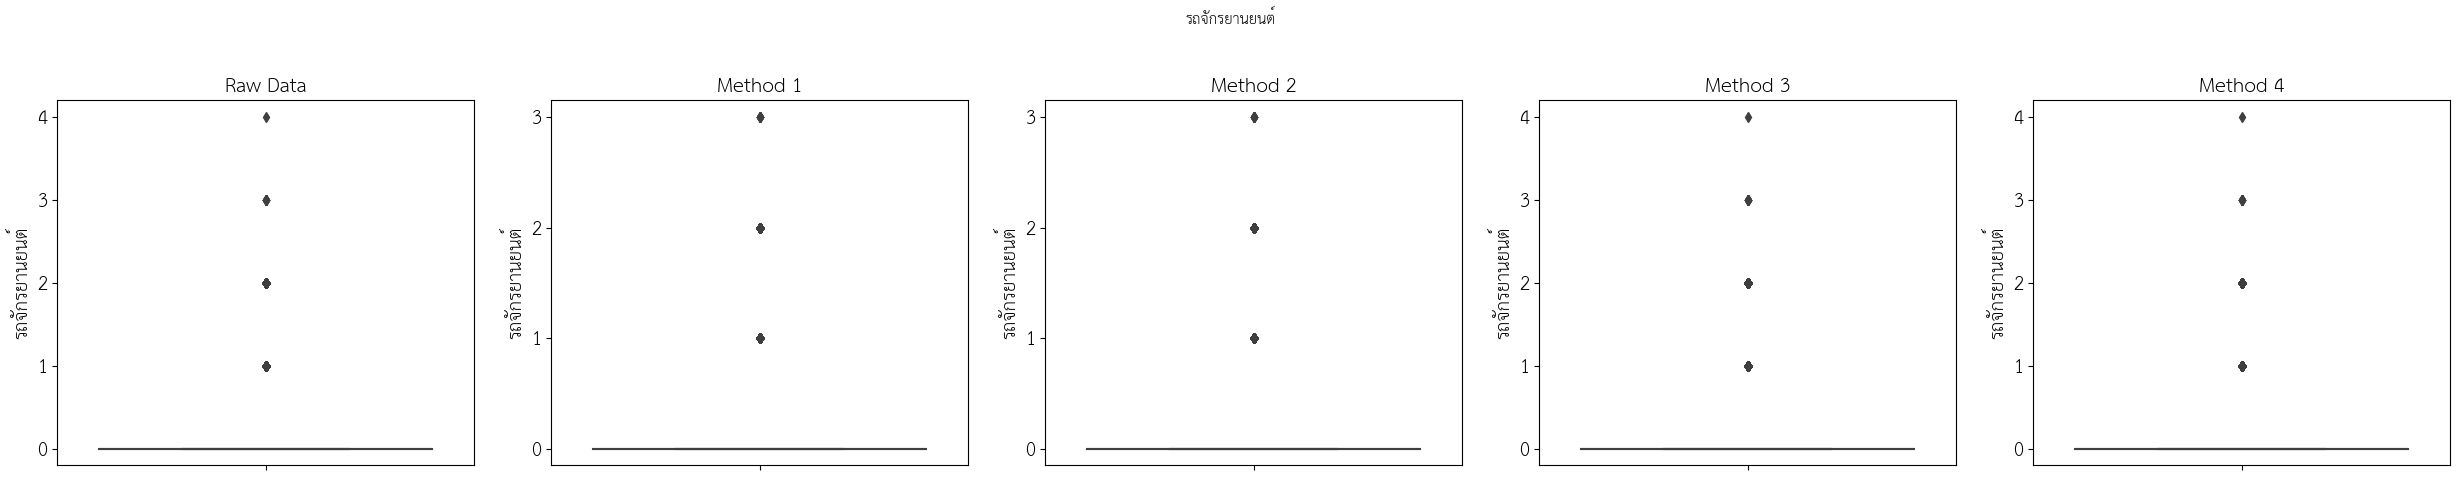

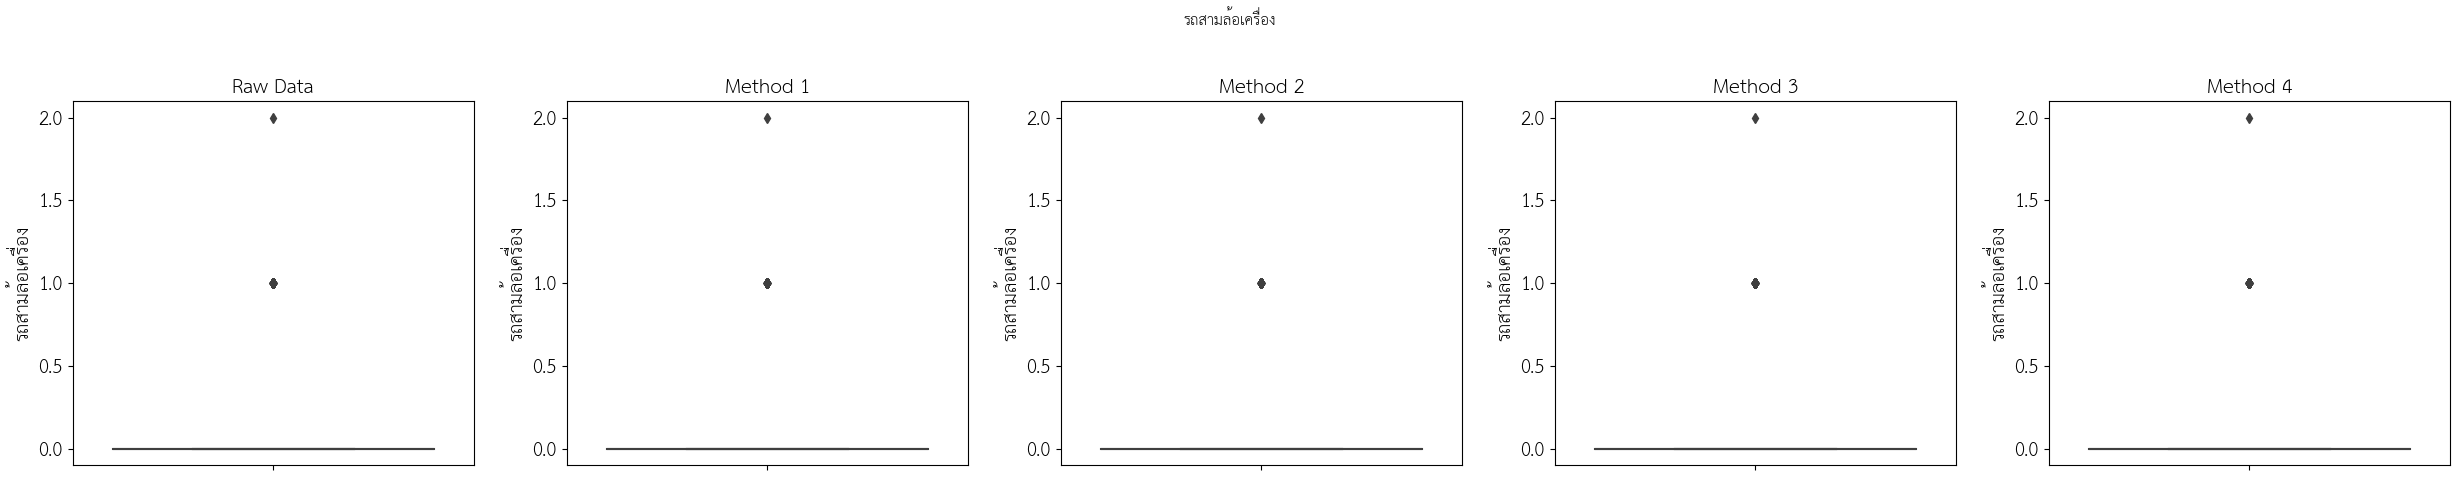

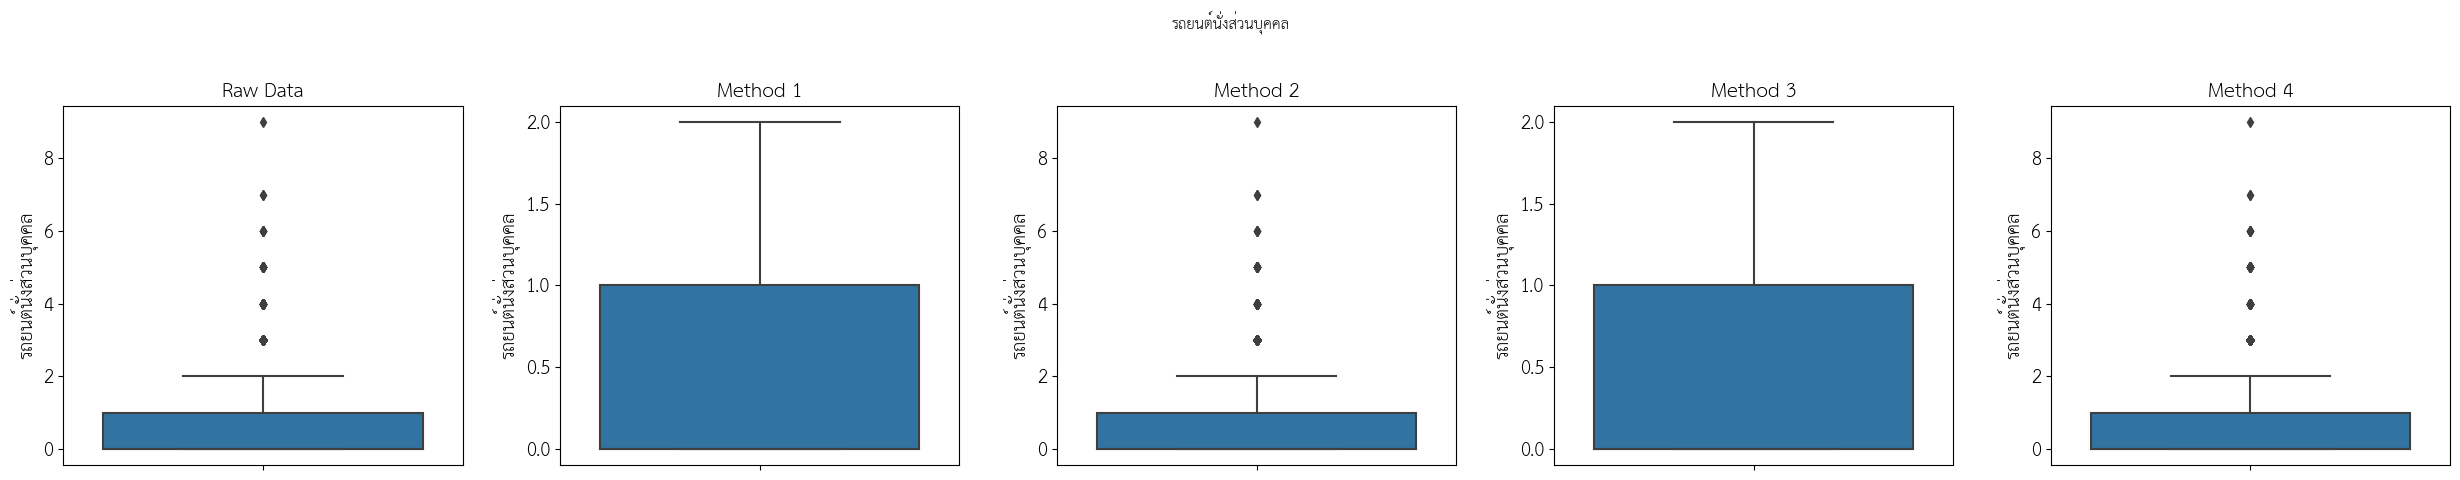

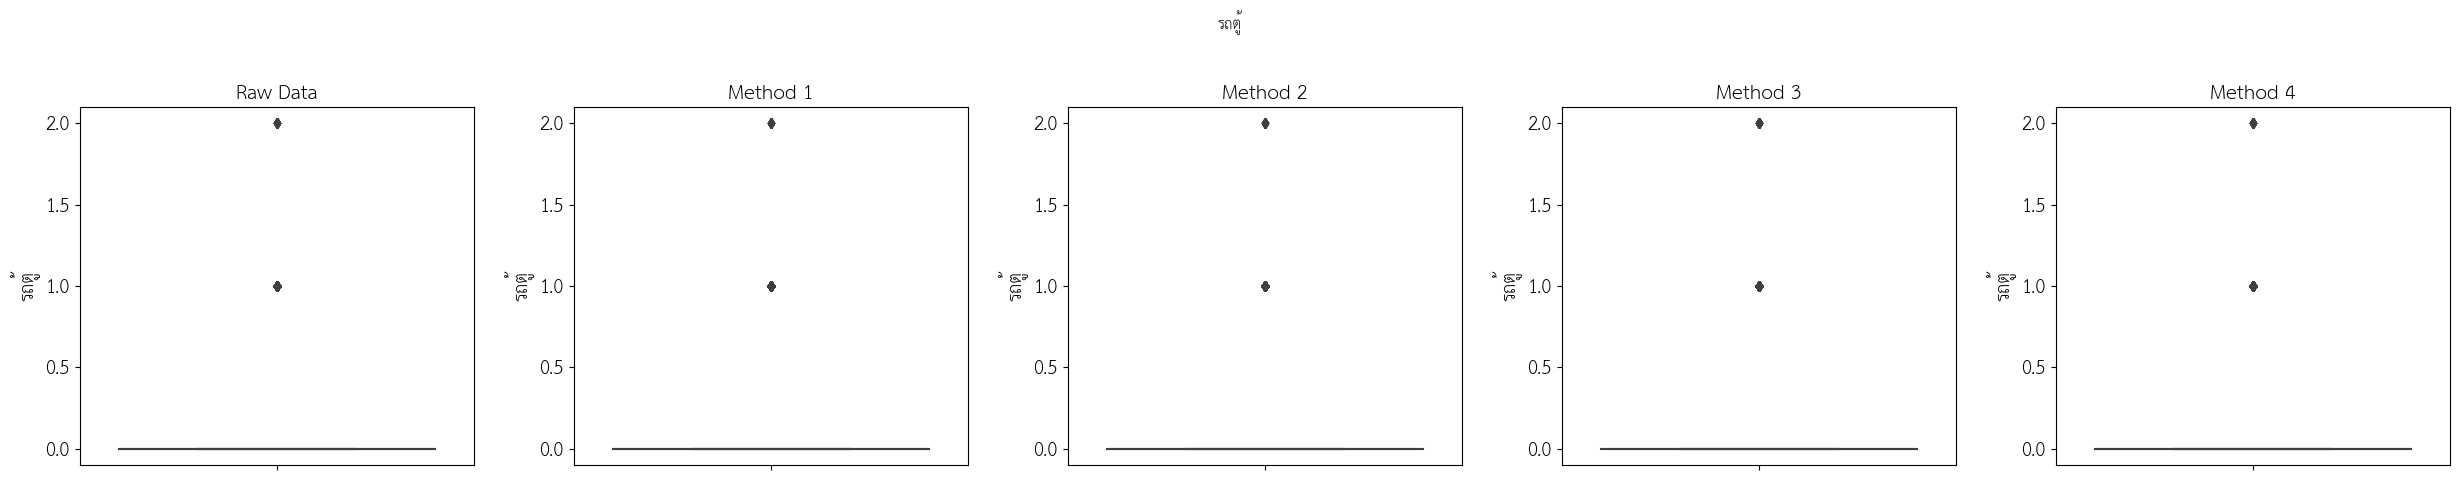

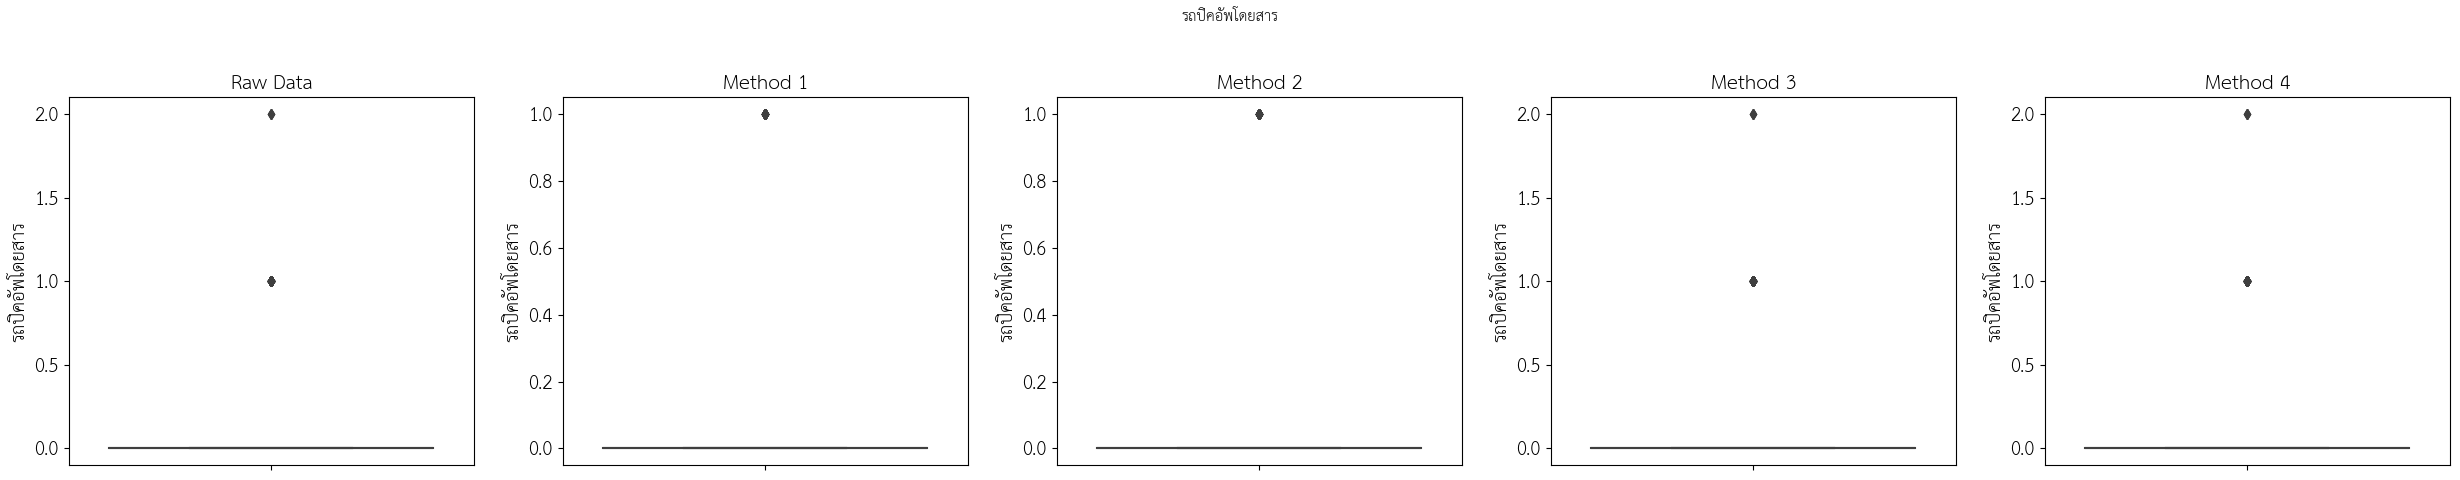

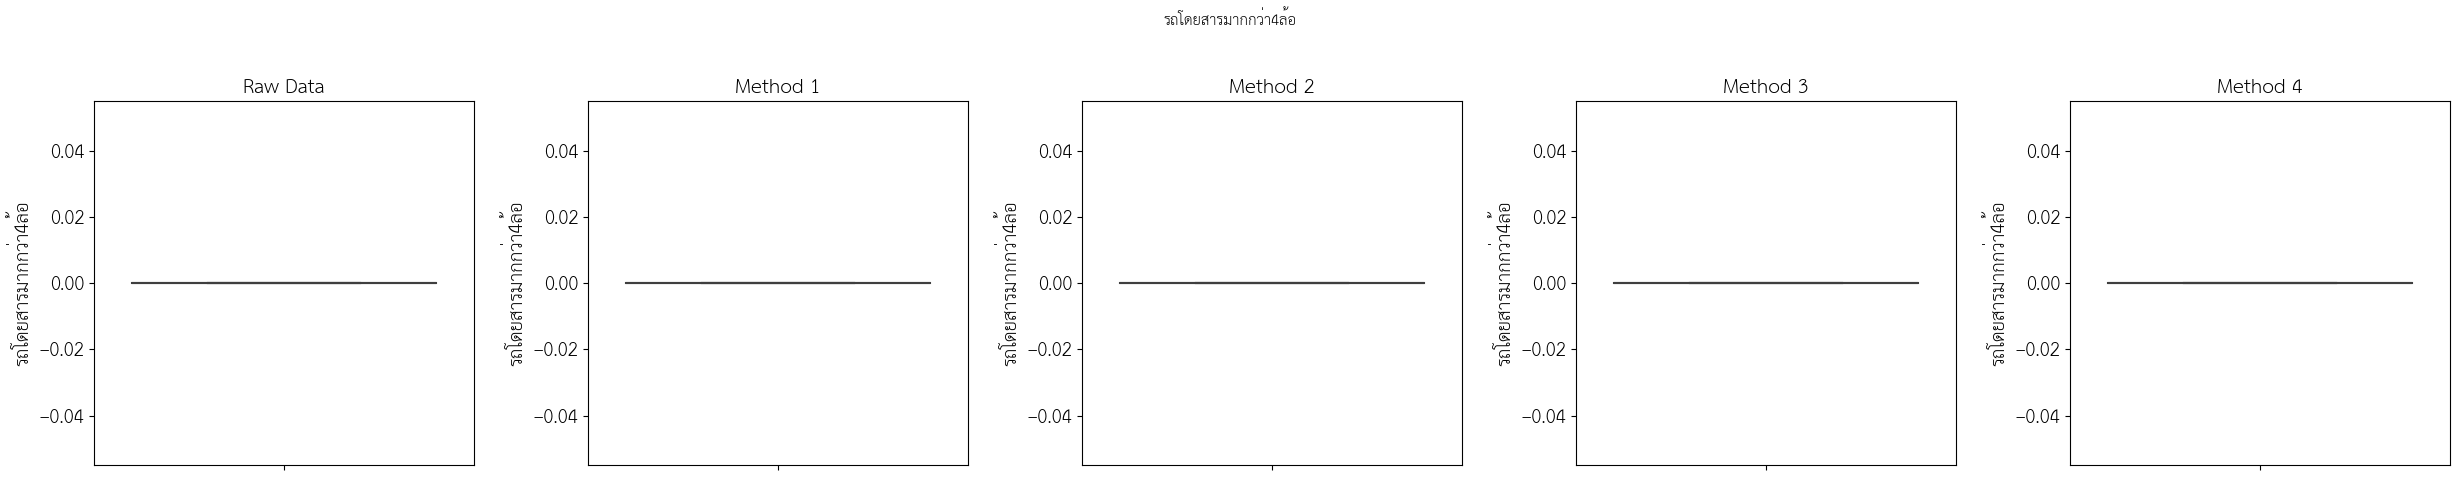

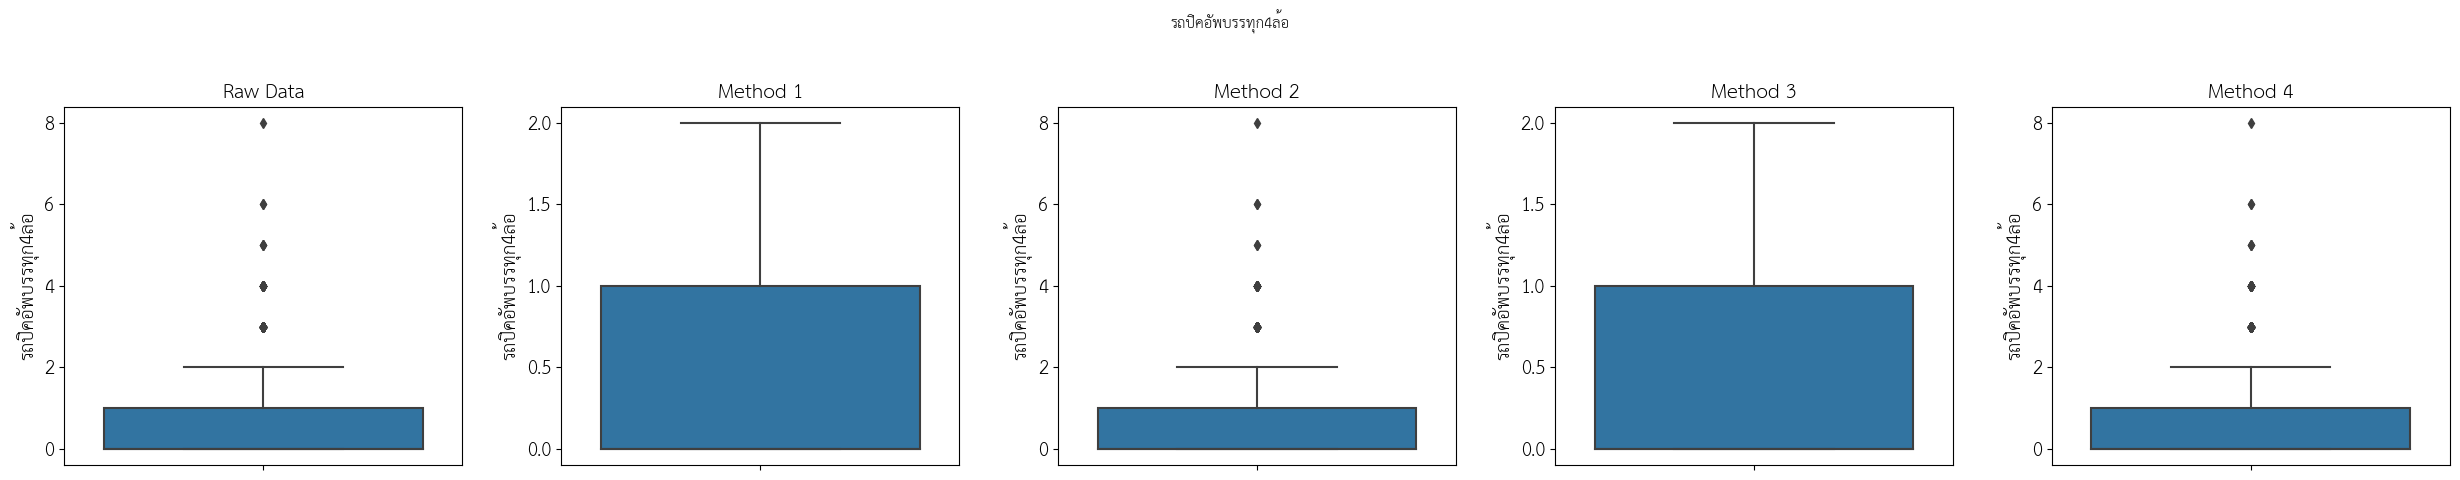

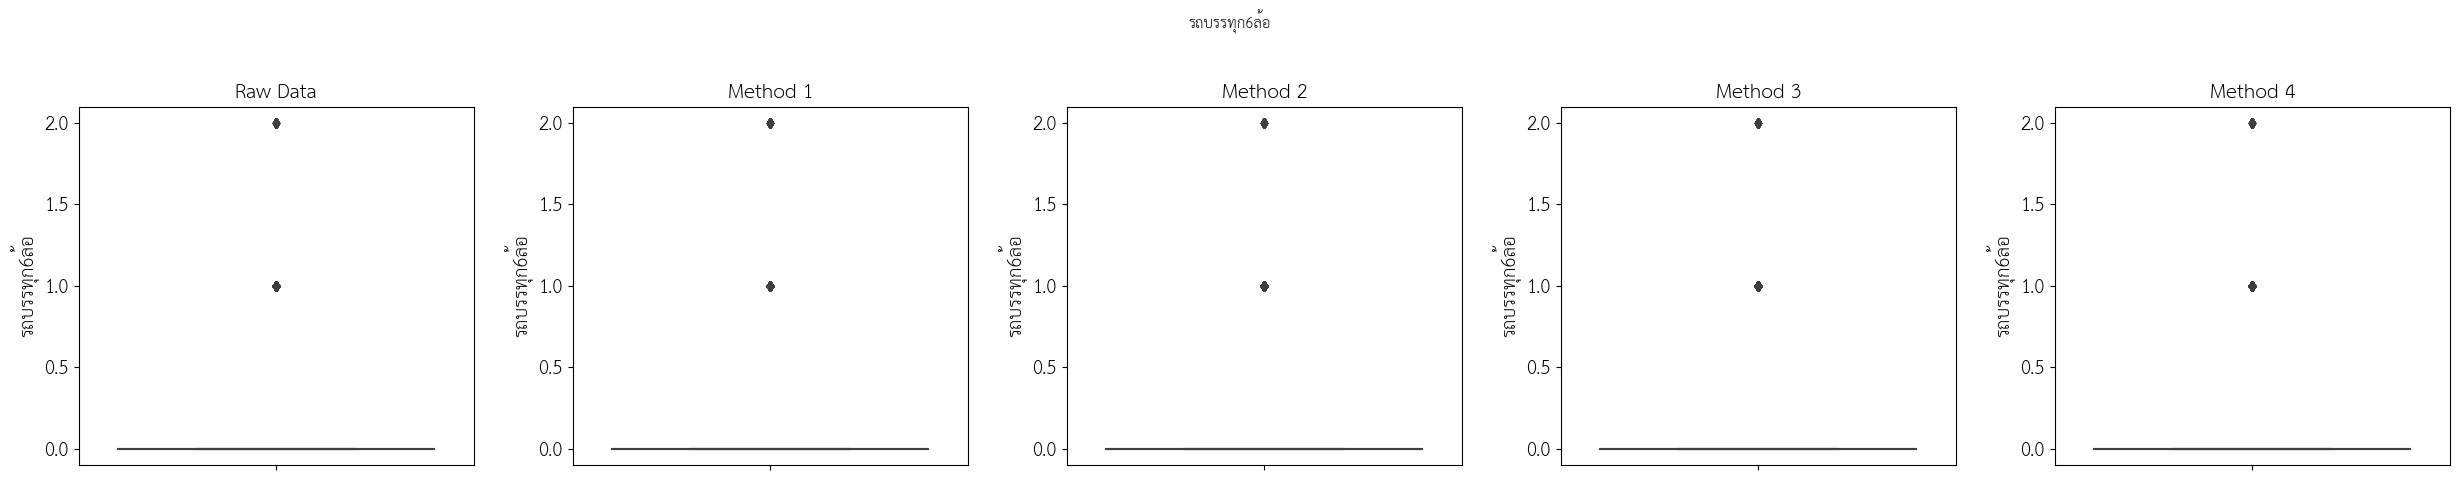

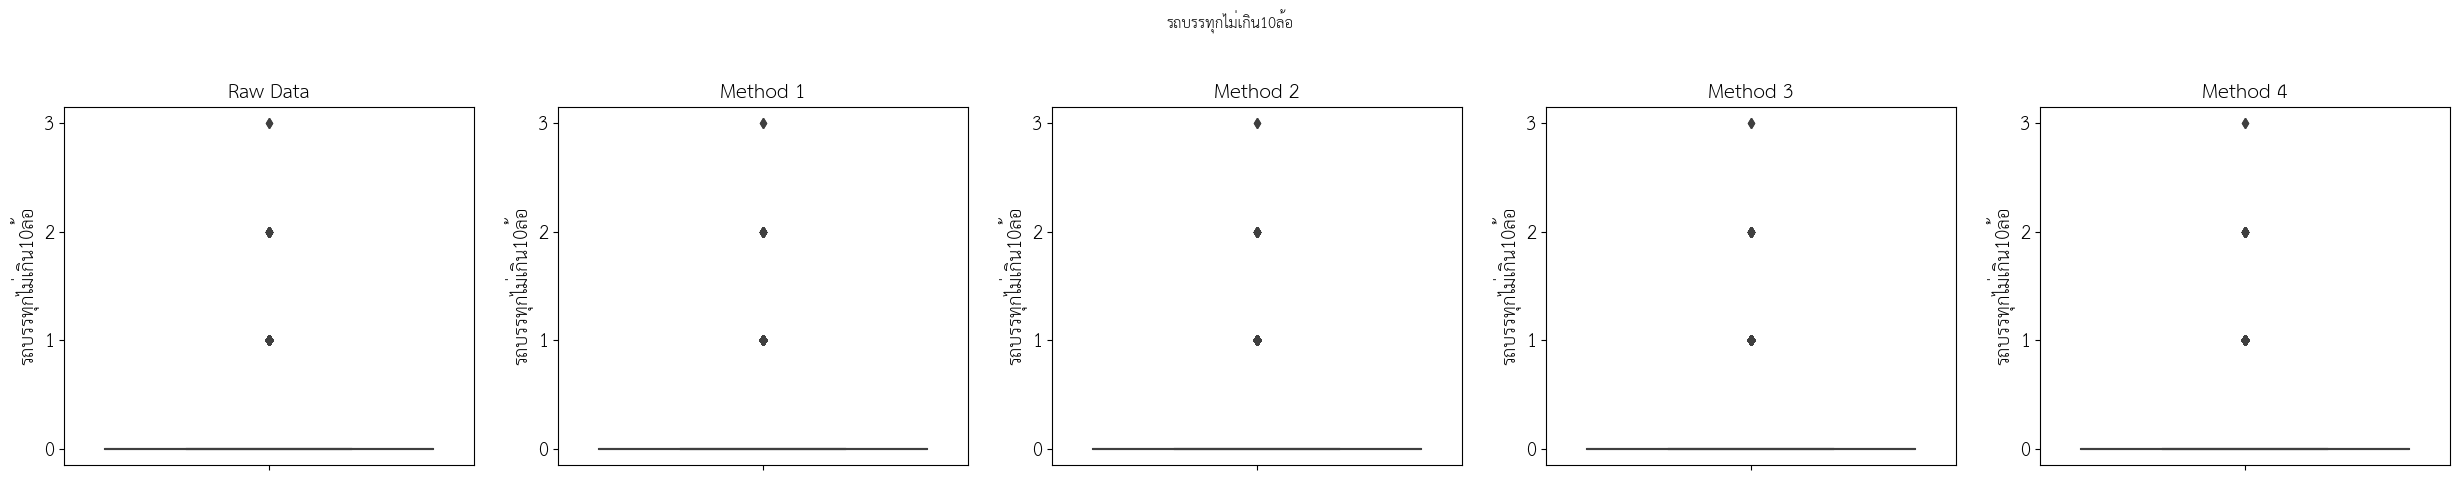

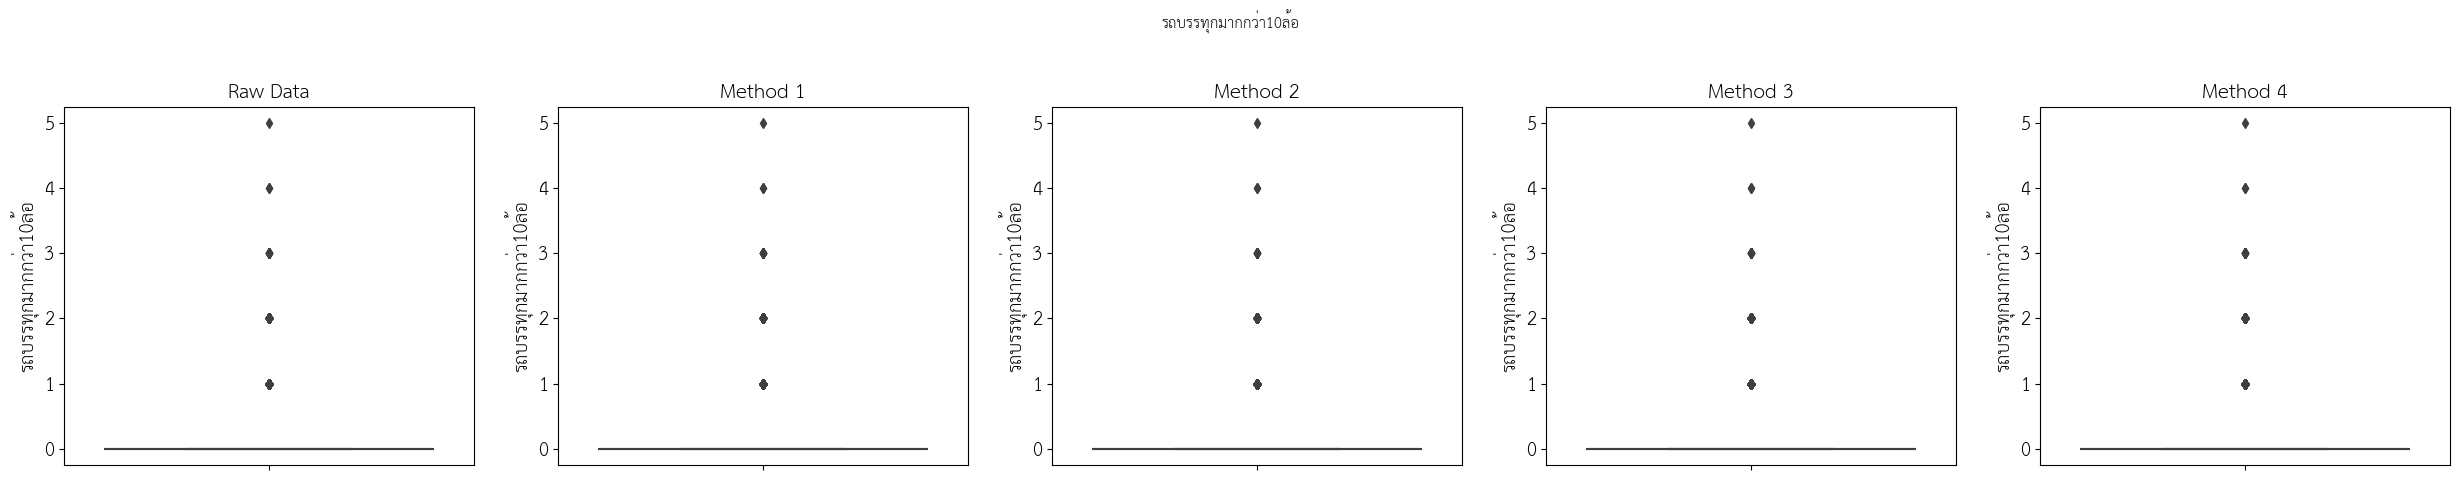

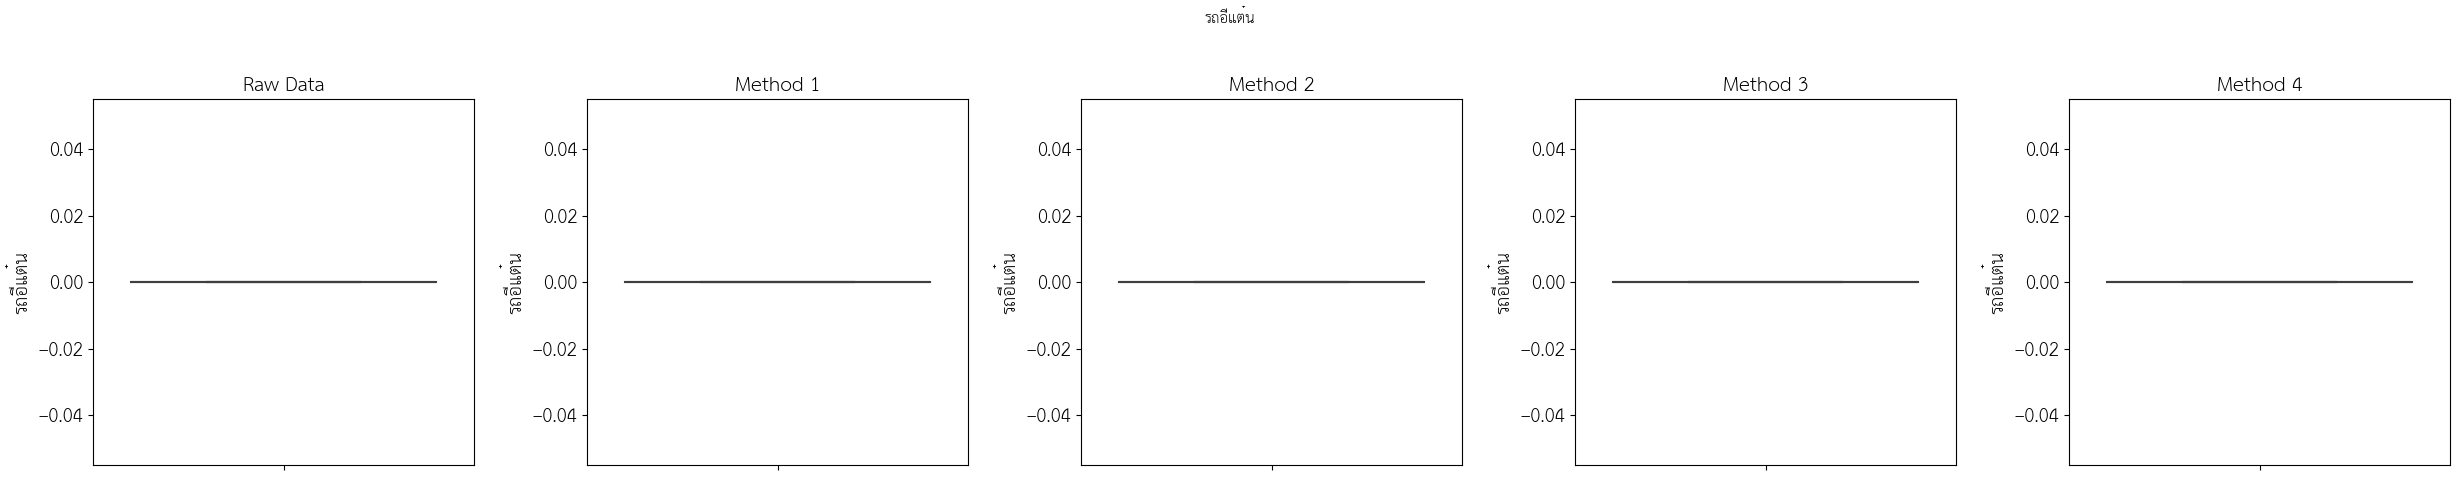

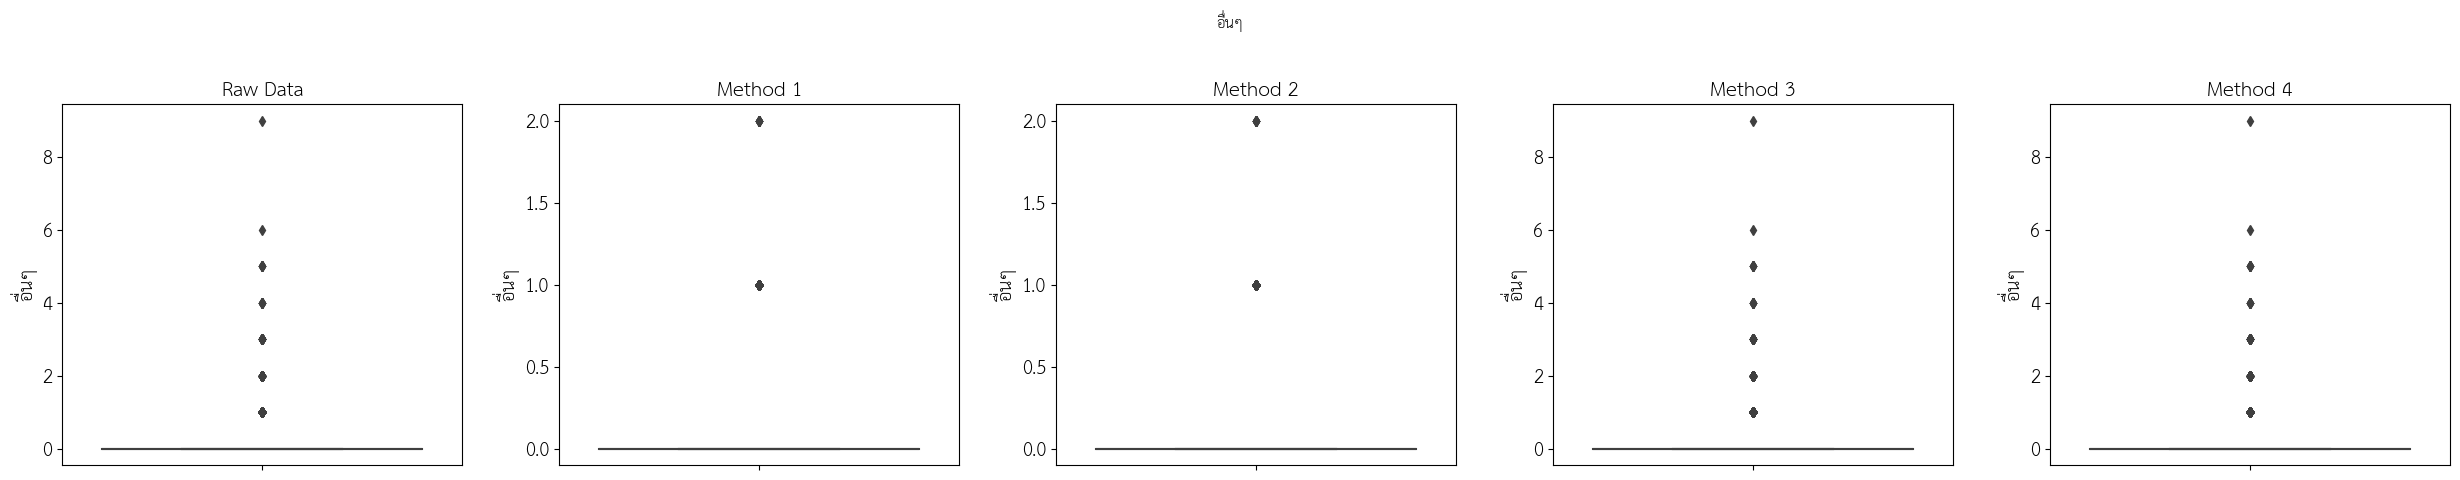

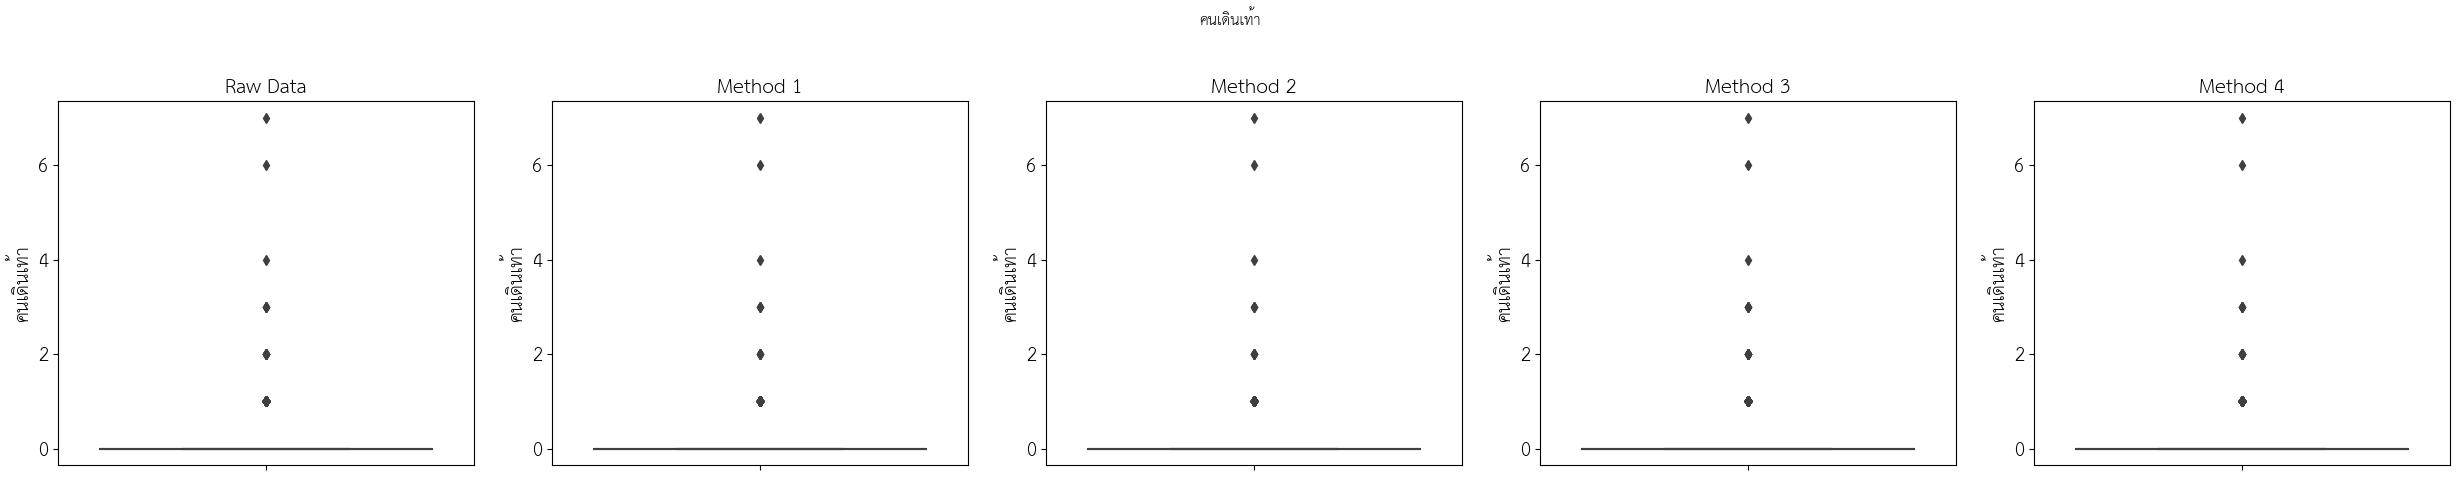

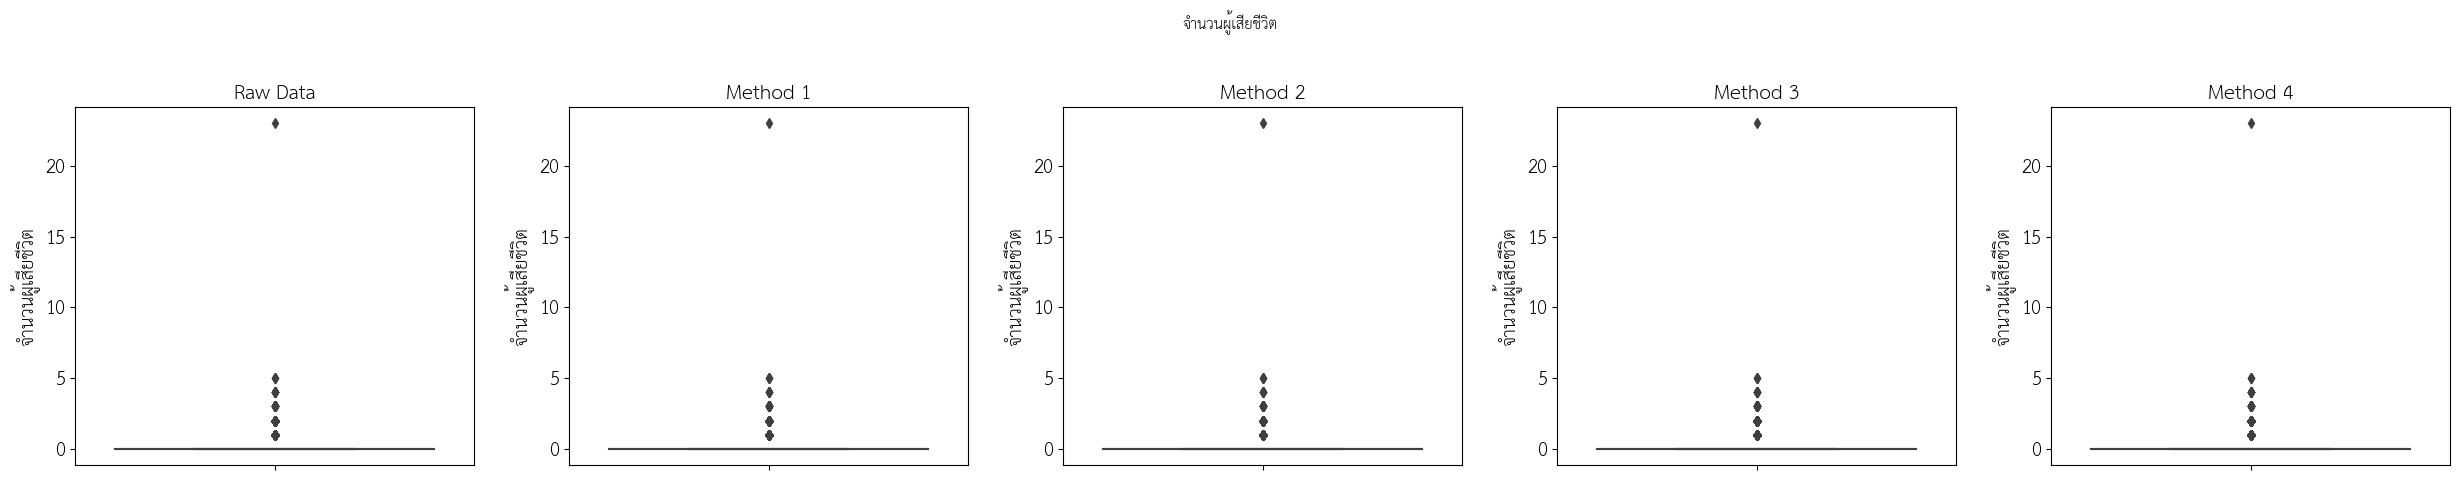

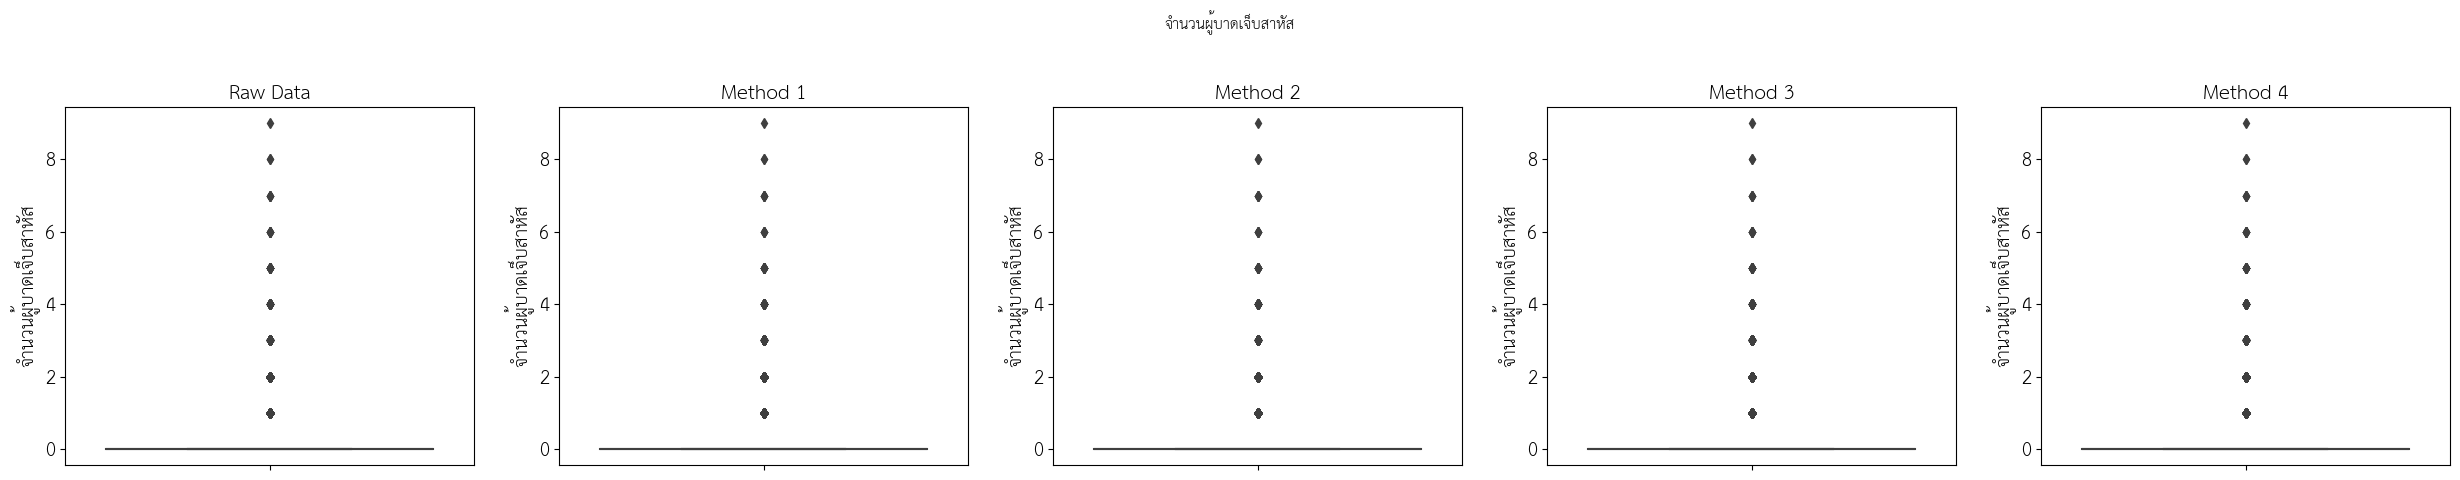

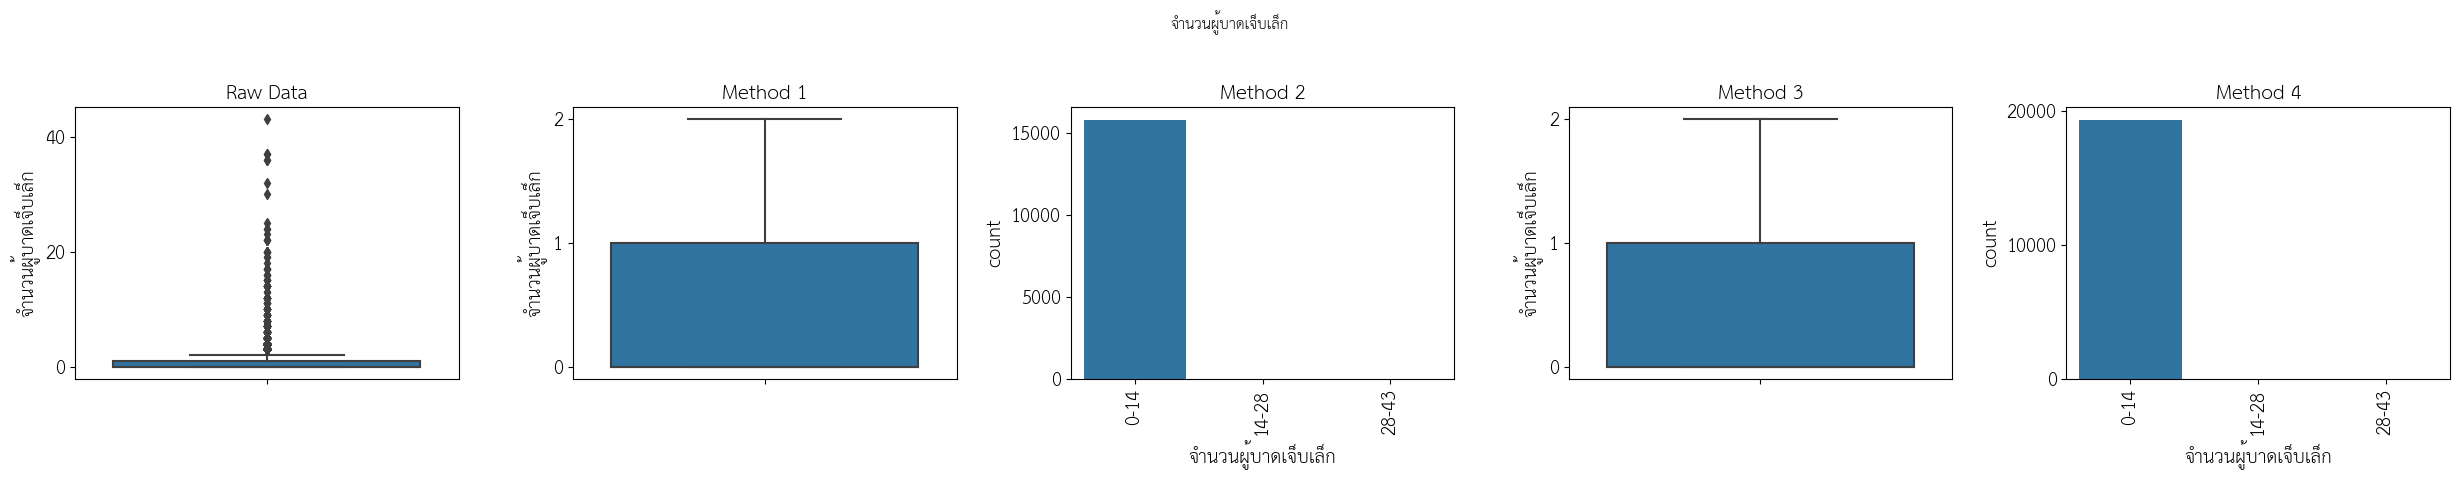

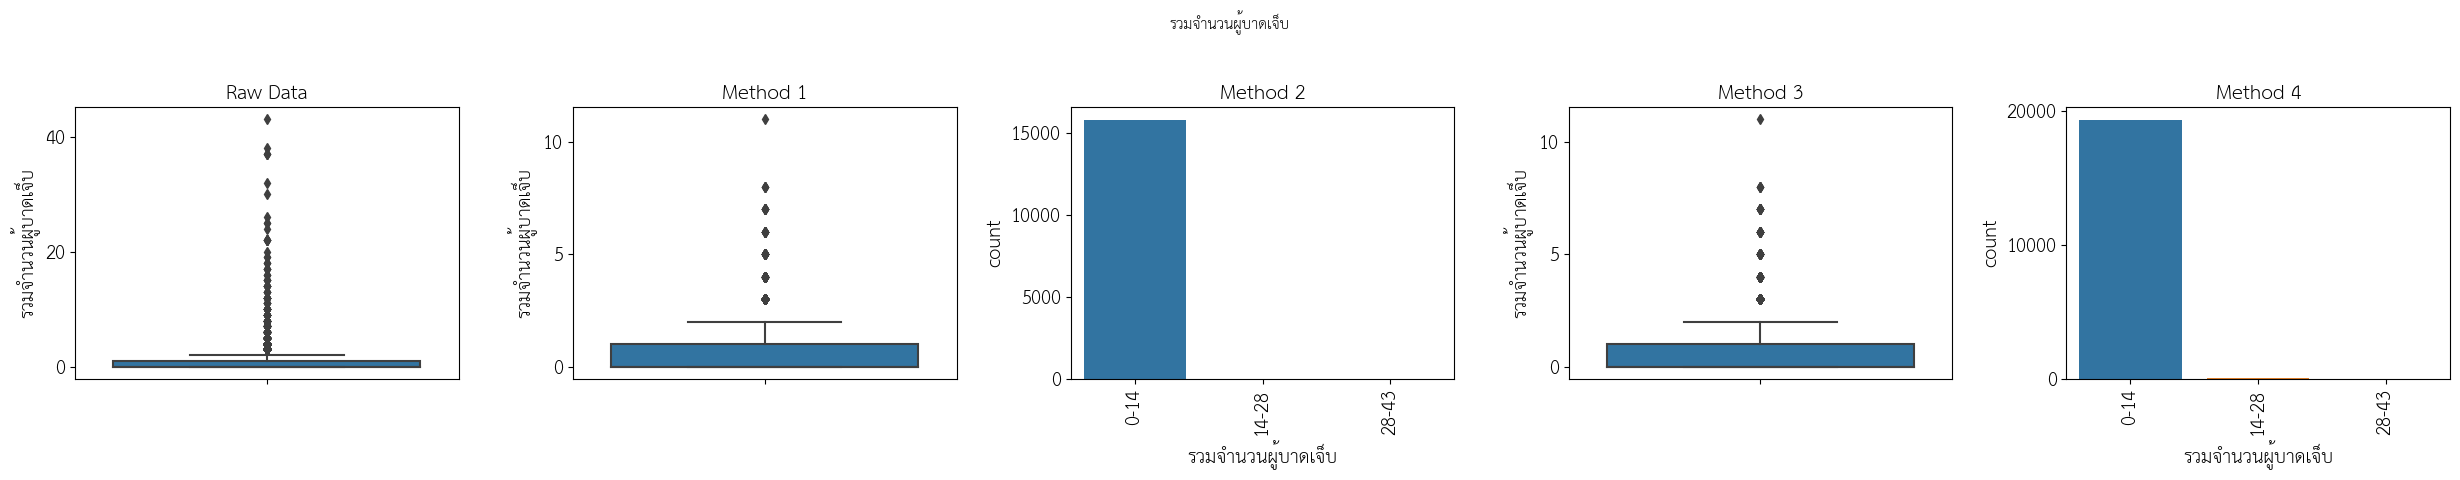

In [38]:
for i in numerical_feature:
    plot_subplots(raw_data,clean_1, clean_2, cleaned_3_df, cleaned_4_df, i)


In [29]:
model_standard.describe().round(3)

,จำนวนรถที่เกิดเหตุ,จำนวนที่เกิดเหตุทั้ง,รถจักรยานยนต์,รถสามล้อเครื่อง,รถยนต์นั่งส่วนบุคคล,รถตู้,รถปิคอัพโดยสาร,รถโดยสารมากกว่า4ล้อ,รถปิคอัพบรรทุก4ล้อ,รถบรรทุก6ล้อ,รถบรรทุกไม่เกิน10ล้อ,รถบรรทุกมากกว่า10ล้อ,รถอีแต๋น,อื่นๆ,คนเดินเท้า,จำนวนผู้เสียชีวิต,จำนวนผู้บาดเจ็บสาหัส,รวมผู้ได้รับผลกระทบ,จำนวนผู้บาดเจ็บเล็ก_0-14,จำนวนผู้บาดเจ็บเล็ก_14-28,จำนวนผู้บาดเจ็บเล็ก_28-43,รวมจำนวนผู้บาดเจ็บ_0-14,รวมจำนวนผู้บาดเจ็บ_14-28,รวมจำนวนผู้บาดเจ็บ_28-43,กลุ่มบริเวณที่เกิดเหตุ_ทางตรง,กลุ่มบริเวณที่เกิดเหตุ_ทางเชื่อม,กลุ่มบริเวณที่เกิดเหตุ_ทางแยก,กลุ่มบริเวณที่เกิดเหตุ_ทางโค้ง,กลุ่มบริเวณที่เกิดเหตุ_อื่น ๆ,กลุ่มลักษณะการเกิดเหตุ_ชนกับคนหรือสิ่งของ,กลุ่มลักษณะการเกิดเหตุ_ชนกับยานพาหนะ,กลุ่มลักษณะการเกิดเหตุ_พลิกคว่ำ/ตกถนน,กลุ่มลักษณะการเกิดเหตุ_อื่นๆ,กลุ่มมูลเหตุ_การไม่เคารพกฎจราจร,กลุ่มมูลเหตุ_ความไม่พร้อมของผู้ขับขี่,กลุ่มมูลเหตุ_ถนนและสิ่งแวดล้อม,กลุ่มมูลเหตุ_พฤติกรรมผู้ขับขี่,กลุ่มมูลเหตุ_สิ่งตัดหน้า/คาดไม่ถึง,กลุ่มมูลเหตุ_สิ่งรบกวน/สมาธิ,กลุ่มมูลเหตุ_อื่นๆ,กลุ่มมูลเหตุ_อุปกรณ์/ระบบยานพาหนะ,กลุ่มมูลเหตุ_ไม่ชำนาญ/ไม่รู้เส้นทาง,กลุ่มสภาพอากาศ_ภัยธรรมชาติ,กลุ่มสภาพอากาศ_วิสัยทัศน์ไม่ดี,กลุ่มสภาพอากาศ_อากาศแจ่มใส,กลุ่มสภาพอากาศ_อื่นๆ,vehicle_group_คนเดินเท้า,vehicle_group_รถขนาดเล็ก/ส่วนบุคคล,vehicle_group_รถบรรทุก/ขนส่งสินค้า,vehicle_group_รถโดยสารสาธารณะ,vehicle_group_อื่นๆ,ภาค_กรุงเทพ,ภาค_กลาง,ภาค_ตะวันตก,ภาค_ตะวันออก,ภาค_ตะวันออกเฉียงเหนือ,ภาค_เหนือ,ภาค_ใต้,มูลค่าความเสียหาย
count,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.0,19391.000,19391.000,19391.000,19391.00,19391.0,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000,19391.000
mean,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.0,0.000,-0.000,0.000,0.00,0.0,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,501511.062
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,1.000,1.000,1.000,1.00,0.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,288877.896
min,-1.919,-1.912,-0.469,-0.080,-0.621,-0.165,-0.072,0.0,-0.822,-0.251,-0.214,-0.34,0.0,-0.261,-0.086,-0.292,-0.261,-0.585,-24.596,-0.036,-0.019,-23.187,-0.039,-0.019,-2.145,-0.108,-0.104,-0.423,-0.068,-0.262,-0.749,-1.114,-0.151,-0.119,-0.319,-0.177,-1.641,-0.290,-0.049,-0.085,-0.202,-0.088,-0.018,-0.361,-2.758,-0.025,-0.043,-1.922,-0.286,-0.080,-0.385,-0.385,-0.563,-0.216,-0.394,-0.470,-0.398,-0.394,116.000
25%,-0.666,-0.673,-0.469,-0.080,-0.621,-0.165,-0.072,0.0,-0.822,-0.251,-0.214,-0.34,0.0,-0.261,-0.086,-0.292,-0.261,-0.585,0.041,-0.036,-0.019,0.043,-0.039,-0.019,0.466,-0.108,-0.104,-0.423,-0.068,-0.262,-0.749,-1.114,-0.151,-0.119,-0.319,-0.177,-1.641,-0.290,-0.049,-0.085,-0.202,-0.088,-0.018,-0.361,0.363,-0.025,-0.043,0.520,-0.286,-0.080,-0.385,-0.385,-0.563,-0.216,-0.394,-0.470,-0.398,-0.394,250751.500
50%,-0.666,-0.673,-0.469,-0.080,-0.621,-0.165,-0.072,0.0,-0.822,-0.251,-0.214,-0.34,0.0,-0.261,-0.086,-0.292,-0.261,0.014,0.041,-0.036,-0.019,0.043,-0.039,-0.019,0.466,-0.108,-0.104,-0.423,-0.068,-0.262,-0.749,0.898,-0.151,-0.119,-0.319,-0.177,0.609,-0.290,-0.049,-0.085,-0.202,-0.088,-0.018,-0.361,0.363,-0.025,-0.043,0.520,-0.286,-0.080,-0.385,-0.385,-0.563,-0.216,-0.394,-0.470,-0.398,-0.394,499825.000
75%,0.587,0.566,-0.469,-0.080,0.846,-0.165,-0.072,

In [25]:
model_min_max.describe()

,จำนวนรถที่เกิดเหตุ,จำนวนที่เกิดเหตุทั้ง,รถจักรยานยนต์,รถสามล้อเครื่อง,รถยนต์นั่งส่วนบุคคล,รถตู้,รถปิคอัพโดยสาร,รถโดยสารมากกว่า4ล้อ,รถปิคอัพบรรทุก4ล้อ,รถบรรทุก6ล้อ,รถบรรทุกไม่เกิน10ล้อ,รถบรรทุกมากกว่า10ล้อ,รถอีแต๋น,อื่นๆ,คนเดินเท้า,จำนวนผู้เสียชีวิต,จำนวนผู้บาดเจ็บสาหัส,รวมผู้ได้รับผลกระทบ,จำนวนผู้บาดเจ็บเล็ก_0-14,จำนวนผู้บาดเจ็บเล็ก_14-28,จำนวนผู้บาดเจ็บเล็ก_28-43,รวมจำนวนผู้บาดเจ็บ_0-14,รวมจำนวนผู้บาดเจ็บ_14-28,รวมจำนวนผู้บาดเจ็บ_28-43,กลุ่มบริเวณที่เกิดเหตุ_ทางตรง,กลุ่มบริเวณที่เกิดเหตุ_ทางเชื่อม,กลุ่มบริเวณที่เกิดเหตุ_ทางแยก,กลุ่มบริเวณที่เกิดเหตุ_ทางโค้ง,กลุ่มบริเวณที่เกิดเหตุ_อื่น ๆ,กลุ่มลักษณะการเกิดเหตุ_ชนกับคนหรือสิ่งของ,กลุ่มลักษณะการเกิดเหตุ_ชนกับยานพาหนะ,กลุ่มลักษณะการเกิดเหตุ_พลิกคว่ำ/ตกถนน,กลุ่มลักษณะการเกิดเหตุ_อื่นๆ,กลุ่มมูลเหตุ_การไม่เคารพกฎจราจร,กลุ่มมูลเหตุ_ความไม่พร้อมของผู้ขับขี่,กลุ่มมูลเหตุ_ถนนและสิ่งแวดล้อม,กลุ่มมูลเหตุ_พฤติกรรมผู้ขับขี่,กลุ่มมูลเหตุ_สิ่งตัดหน้า/คาดไม่ถึง,กลุ่มมูลเหตุ_สิ่งรบกวน/สมาธิ,กลุ่มมูลเหตุ_อื่นๆ,กลุ่มมูลเหตุ_อุปกรณ์/ระบบยานพาหนะ,กลุ่มมูลเหตุ_ไม่ชำนาญ/ไม่รู้เส้นทาง,กลุ่มสภาพอากาศ_ภัยธรรมชาติ,กลุ่มสภาพอากาศ_วิสัยทัศน์ไม่ดี,กลุ่มสภาพอากาศ_อากาศแจ่มใส,กลุ่มสภาพอากาศ_อื่นๆ,vehicle_group_คนเดินเท้า,vehicle_group_รถขนาดเล็ก/ส่วนบุคคล,vehicle_group_รถบรรทุก/ขนส่งสินค้า,vehicle_group_รถโดยสารสาธารณะ,vehicle_group_อื่นๆ,ภาค_กรุงเทพ,ภาค_กลาง,ภาค_ตะวันตก,ภาค_ตะวันออก,ภาค_ตะวันออกเฉียงเหนือ,ภาค_เหนือ,ภาค_ใต้,มูลค่าความเสียหาย
count,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.0,19391.000000,19391.00000,19391.000000,19391.000000,19391.0,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.00000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000
mean,0.090099,0.090770,0.054368,0.003223,0.047009,0.014053,0.002759,0.0,0.065913,0.03169,0.015815,0.024259,0.0,0.010182,0.001628,0.005262,0.014147,0.021717,0.998350,0.001289,0.000361,0.998143,0.001496,0.000361,0.821412,0.011552,0.010623,0.151771,0.004641,0.064360,0.359548,0.55371,0.022382,0.014027,0.092466,0.030272,0.729307,0.077459,0.002424,0.007220,0.039090,0.007736,0.000309,0.115260,0.883812,0.000619,0.001805,0.787015,0.075808,0.006292,0.129081,0.128823,0.240524,0.044402,0.134495,0.180754,0.136507,0.134495,501511.062142
std,0.046961,0.047486,0.116018,0.040337,0.075728,0.084948,0.038070,0.0,0.080197,0.12609,0.073796,0.071277,0.0,0.038945,0.018986,0.017993,0.054111,0.037111,0.040591,0.035884,0.018997,0.043049,0.038644,0.018997,0.383017,0.106859,0.102524,0.358808,0.067971,0.245399,0.479880,0.49712,0.147925,0.117606,0.289690,0.171339,0.444329,0.267325,0.049174,0.084665,0.193815,0.087613,0.017588,0.319343,0.320458,0.024870,0.042448,0.409428,0.264698,0.079072,0.335298,0.335012,0.427413,0.205992,0.341193,0.384824,0.343335,0.341193,288877.896327
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116.000000
25%,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [18]:
model_min_max

,จำนวนรถที่เกิดเหตุ,จำนวนที่เกิดเหตุทั้ง,รถจักรยานยนต์,รถสามล้อเครื่อง,รถยนต์นั่งส่วนบุคคล,รถตู้,รถปิคอัพโดยสาร,รถโดยสารมากกว่า4ล้อ,รถปิคอัพบรรทุก4ล้อ,รถบรรทุก6ล้อ,รถบรรทุกไม่เกิน10ล้อ,รถบรรทุกมากกว่า10ล้อ,รถอีแต๋น,อื่นๆ,คนเดินเท้า,จำนวนผู้เสียชีวิต,จำนวนผู้บาดเจ็บสาหัส,รวมผู้ได้รับผลกระทบ,จำนวนผู้บาดเจ็บเล็ก_0-14,จำนวนผู้บาดเจ็บเล็ก_14-28,จำนวนผู้บาดเจ็บเล็ก_28-43,รวมจำนวนผู้บาดเจ็บ_0-14,รวมจำนวนผู้บาดเจ็บ_14-28,รวมจำนวนผู้บาดเจ็บ_28-43,กลุ่มบริเวณที่เกิดเหตุ_ทางตรง,กลุ่มบริเวณที่เกิดเหตุ_ทางเชื่อม,กลุ่มบริเวณที่เกิดเหตุ_ทางแยก,กลุ่มบริเวณที่เกิดเหตุ_ทางโค้ง,กลุ่มบริเวณที่เกิดเหตุ_อื่น ๆ,กลุ่มลักษณะการเกิดเหตุ_ชนกับคนหรือสิ่งของ,กลุ่มลักษณะการเกิดเหตุ_ชนกับยานพาหนะ,กลุ่มลักษณะการเกิดเหตุ_พลิกคว่ำ/ตกถนน,กลุ่มลักษณะการเกิดเหตุ_อื่นๆ,กลุ่มมูลเหตุ_การไม่เคารพกฎจราจร,กลุ่มมูลเหตุ_ความไม่พร้อมของผู้ขับขี่,กลุ่มมูลเหตุ_ถนนและสิ่งแวดล้อม,กลุ่มมูลเหตุ_พฤติกรรมผู้ขับขี่,กลุ่มมูลเหตุ_สิ่งตัดหน้า/คาดไม่ถึง,กลุ่มมูลเหตุ_สิ่งรบกวน/สมาธิ,กลุ่มมูลเหตุ_อื่นๆ,กลุ่มมูลเหตุ_อุปกรณ์/ระบบยานพาหนะ,กลุ่มมูลเหตุ_ไม่ชำนาญ/ไม่รู้เส้นทาง,กลุ่มสภาพอากาศ_ภัยธรรมชาติ,กลุ่มสภาพอากาศ_วิสัยทัศน์ไม่ดี,กลุ่มสภาพอากาศ_อากาศแจ่มใส,กลุ่มสภาพอากาศ_อื่นๆ,vehicle_group_คนเดินเท้า,vehicle_group_รถขนาดเล็ก/ส่วนบุคคล,vehicle_group_รถบรรทุก/ขนส่งสินค้า,vehicle_group_รถโดยสารสาธารณะ,vehicle_group_อื่นๆ,ภาค_กรุงเทพ,ภาค_กลาง,ภาค_ตะวันตก,ภาค_ตะวันออก,ภาค_ตะวันออกเฉียงเหนือ,ภาค_เหนือ,ภาค_ใต้,มูลค่าความเสียหาย
0,0.058824,0.058824,0.25,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.022222,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62536
1,0.058824,0.058824,0.25,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.022222,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,653759
2,0.058824,0.058824,0.25,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.022222,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,423925
3,0.058824,0.176471,0.25,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.111111,0.044444,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,406010
4,0.058824,0.058824,0.00,0.0,0.000000,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.022222,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,454972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19386,0.117647,0.117647,0.25,0.0,0.111111,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.022222,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,857762
19387,0.117647,0.117647,0.00,0.0,0.111111,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,141167
19388,0.235294,0.235294,0.00,0.0,0.111111,0.0,0.0,0.0,0.375,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.133333,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,764155
19389,0.058824,0.058824,0.00,0.0,0.111111,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.022222,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0

In [13]:
model_min_max.describe()

,จำนวนรถที่เกิดเหตุ,จำนวนที่เกิดเหตุทั้ง,รถจักรยานยนต์,รถสามล้อเครื่อง,รถยนต์นั่งส่วนบุคคล,รถตู้,รถปิคอัพโดยสาร,รถโดยสารมากกว่า4ล้อ,รถปิคอัพบรรทุก4ล้อ,รถบรรทุก6ล้อ,รถบรรทุกไม่เกิน10ล้อ,รถบรรทุกมากกว่า10ล้อ,รถอีแต๋น,อื่นๆ,คนเดินเท้า,จำนวนผู้เสียชีวิต,จำนวนผู้บาดเจ็บสาหัส,รวมผู้ได้รับผลกระทบ,กลุ่มบริเวณที่เกิดเหตุ_ทางตรง,กลุ่มบริเวณที่เกิดเหตุ_ทางเชื่อม,กลุ่มบริเวณที่เกิดเหตุ_ทางแยก,กลุ่มบริเวณที่เกิดเหตุ_ทางโค้ง,กลุ่มบริเวณที่เกิดเหตุ_อื่น ๆ,กลุ่มลักษณะการเกิดเหตุ_ชนกับคนหรือสิ่งของ,กลุ่มลักษณะการเกิดเหตุ_ชนกับยานพาหนะ,กลุ่มลักษณะการเกิดเหตุ_พลิกคว่ำ/ตกถนน,กลุ่มลักษณะการเกิดเหตุ_อื่นๆ,กลุ่มมูลเหตุ_การไม่เคารพกฎจราจร,กลุ่มมูลเหตุ_ความไม่พร้อมของผู้ขับขี่,กลุ่มมูลเหตุ_ถนนและสิ่งแวดล้อม,กลุ่มมูลเหตุ_พฤติกรรมผู้ขับขี่,กลุ่มมูลเหตุ_สิ่งตัดหน้า/คาดไม่ถึง,กลุ่มมูลเหตุ_สิ่งรบกวน/สมาธิ,กลุ่มมูลเหตุ_อื่นๆ,กลุ่มมูลเหตุ_อุปกรณ์/ระบบยานพาหนะ,กลุ่มมูลเหตุ_ไม่ชำนาญ/ไม่รู้เส้นทาง,กลุ่มสภาพอากาศ_ภัยธรรมชาติ,กลุ่มสภาพอากาศ_วิสัยทัศน์ไม่ดี,กลุ่มสภาพอากาศ_อากาศแจ่มใส,กลุ่มสภาพอากาศ_อื่นๆ,vehicle_group_คนเดินเท้า,vehicle_group_รถขนาดเล็ก/ส่วนบุคคล,vehicle_group_รถบรรทุก/ขนส่งสินค้า,vehicle_group_รถโดยสารสาธารณะ,vehicle_group_อื่นๆ,ภาค_กรุงเทพ,ภาค_กลาง,ภาค_ตะวันตก,ภาค_ตะวันออก,ภาค_ตะวันออกเฉียงเหนือ,ภาค_เหนือ,ภาค_ใต้,มูลค่าความเสียหาย
count,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.0,19391.000000,19391.00000,19391.000000,19391.000000,19391.0,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.00000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000
mean,0.090099,0.090770,0.054368,0.003223,0.047009,0.014053,0.002759,0.0,0.065913,0.03169,0.015815,0.024259,0.0,0.010182,0.001628,0.005262,0.014147,0.021717,0.821412,0.011552,0.010623,0.151771,0.004641,0.064360,0.359548,0.55371,0.022382,0.014027,0.092466,0.030272,0.729307,0.077459,0.002424,0.007220,0.039090,0.007736,0.000309,0.115260,0.883812,0.000619,0.001805,0.787015,0.075808,0.006292,0.129081,0.128823,0.240524,0.044402,0.134495,0.180754,0.136507,0.134495,501511.062142
std,0.046961,0.047486,0.116018,0.040337,0.075728,0.084948,0.038070,0.0,0.080197,0.12609,0.073796,0.071277,0.0,0.038945,0.018986,0.017993,0.054111,0.037111,0.383017,0.106859,0.102524,0.358808,0.067971,0.245399,0.479880,0.49712,0.147925,0.117606,0.289690,0.171339,0.444329,0.267325,0.049174,0.084665,0.193815,0.087613,0.017588,0.319343,0.320458,0.024870,0.042448,0.409428,0.264698,0.079072,0.335298,0.335012,0.427413,0.205992,0.341193,0.384824,0.343335,0.341193,288877.896327
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116.000000
25%,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,250751.500000
50%,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.022222,1.000000,0.000000,0.000000,0.000000,

### แบบที่ 1 :
* Categorical Feature : group ข้อมูลเป็นกลุ่มใหญ่ ๆ และตัด row ที่มี missing value ออก
* Numerical : นำ Row ที่เป็น Outlier และ Missing Value ออก

In [ ]:
columns_to_clean = [
    'จังหวัด', 'รถคันที่1', 'บริเวณที่เกิดเหตุ', 'มูลเหตุสันนิษฐาน', 'ลักษณะการเกิดอุบัติเ', 
    'สภาพอากาศ', 'จำนวนรถที่เกิดเหตุ', 'จำนวนที่เกิดเหตุทั้ง', 'รถจักรยานยนต์', 'รถสามล้อเครื่อง', 
    'รถยนต์นั่งส่วนบุคคล', 'รถตู้', 'รถปิคอัพโดยสาร', 'รถโดยสารมากกว่า4ล้อ', 'รถปิคอัพบรรทุก4ล้อ', 
    'รถบรรทุก6ล้อ', 'รถบรรทุกไม่เกิน10ล้อ', 'รถบรรทุกมากกว่า10ล้อ', 'รถอีแต๋น', 'อื่นๆ', 'คนเดินเท้า', 
    'จำนวนผู้เสียชีวิต', 'จำนวนผู้บาดเจ็บสาหัส', 'จำนวนผู้บาดเจ็บเล็ก', 'รวมจำนวนผู้บาดเจ็บ', 'มูลค่าความเสียหาย'
]

In [ ]:
cleaned_1_df = df.dropna(subset=columns_to_clean)
cleaned_1_df = remove_outliers(cleaned_1_df,numerical_feature)

cleaned_1_df = group_categorical_feature(cleaned_1_df)
cleaned_1_df = recalculate_accident_number(cleaned_1_df)

# Model Development
to_delete = ['LATITUDE', 'LONGITUDE','จังหวัด', 'รถคันที่1', 'บริเวณที่เกิดเหตุ', 'มูลเหตุสันนิษฐาน',
             'ลักษณะการเกิดอุบัติเ', 'สภาพอากาศ']
model_1 = cleaned_1_df.drop(to_delete,axis=1)
model_1 = encode_categorical_features(model_1,target_col = 'มูลค่าความเสียหาย')

# Scale Different Way
model_1_standard = scale_data(model_1,scale_by='standard_scaler')
model_1_minmax = scale_data(model_1,scale_by='min_max')

In [ ]:
cleaned_1_df.to_csv('./output/data_after_clean_1.csv',encoding='utf-8-sig',index = False)

### แบบที่ 2 :
* Categorical Feature : group ข้อมูลเป็นกลุ่มใหญ่ ๆ และเติม Missing value ด้วย Mode
* Numerical : เติม Missing value ด้วย median และ cap ค่า outlier

In [ ]:
cleaned_2_df = clean_by_cap_and_fill(df,numerical_feature,categorical_feature,province_json_path)

# Model Development
to_delete = ['LATITUDE', 'LONGITUDE','จังหวัด', 'รถคันที่1', 'บริเวณที่เกิดเหตุ', 'มูลเหตุสันนิษฐาน',
             'ลักษณะการเกิดอุบัติเ', 'สภาพอากาศ']

irrelevant_column = ['ปีที่เกิดเหตุ', 'วันที่เกิดเหตุ', 'เวลา', 'วันที่รายงาน',
                     'เวลาที่รายงาน', 'ACC_CODE', 'หน่วยงาน', 'สายทางหน่วยงาน', 
                     'รหัสสายทาง','สายทาง', 'KM']

model_2 = cleaned_2_df.drop(to_delete,axis=1)
model_2 = model_2.drop(irrelevant_column,axis=1)
model_2 = encode_categorical_features(model_2,target_col = 'มูลค่าความเสียหาย')

# Scale Different Way
model_2_standard = scale_data(model_2,scale_by='standard_scaler')
model_2_minmax = scale_data(model_2,scale_by='min_max')

In [ ]:
model_2_minmax.describe()

,จำนวนรถที่เกิดเหตุ,จำนวนที่เกิดเหตุทั้ง,รถจักรยานยนต์,รถสามล้อเครื่อง,รถยนต์นั่งส่วนบุคคล,รถตู้,รถปิคอัพโดยสาร,รถโดยสารมากกว่า4ล้อ,รถปิคอัพบรรทุก4ล้อ,รถบรรทุก6ล้อ,รถบรรทุกไม่เกิน10ล้อ,รถบรรทุกมากกว่า10ล้อ,รถอีแต๋น,อื่นๆ,คนเดินเท้า,จำนวนผู้เสียชีวิต,จำนวนผู้บาดเจ็บสาหัส,จำนวนผู้บาดเจ็บเล็ก,รวมจำนวนผู้บาดเจ็บ,กลุ่มบริเวณที่เกิดเหตุ_ทางตรง,กลุ่มบริเวณที่เกิดเหตุ_ทางเชื่อม,กลุ่มบริเวณที่เกิดเหตุ_ทางแยก,กลุ่มบริเวณที่เกิดเหตุ_ทางโค้ง,กลุ่มบริเวณที่เกิดเหตุ_อื่น ๆ,กลุ่มลักษณะการเกิดเหตุ_ชนกับคนหรือสิ่งของ,กลุ่มลักษณะการเกิดเหตุ_ชนกับยานพาหนะ,กลุ่มลักษณะการเกิดเหตุ_พลิกคว่ำ/ตกถนน,กลุ่มลักษณะการเกิดเหตุ_อื่นๆ,กลุ่มมูลเหตุ_การไม่เคารพกฎจราจร,กลุ่มมูลเหตุ_ความไม่พร้อมของผู้ขับขี่,กลุ่มมูลเหตุ_ถนนและสิ่งแวดล้อม,กลุ่มมูลเหตุ_พฤติกรรมผู้ขับขี่,กลุ่มมูลเหตุ_สิ่งตัดหน้า/คาดไม่ถึง,กลุ่มมูลเหตุ_สิ่งรบกวน/สมาธิ,กลุ่มมูลเหตุ_อื่นๆ,กลุ่มมูลเหตุ_อุปกรณ์/ระบบยานพาหนะ,กลุ่มมูลเหตุ_ไม่ชำนาญ/ไม่รู้เส้นทาง,กลุ่มสภาพอากาศ_ภัยธรรมชาติ,กลุ่มสภาพอากาศ_วิสัยทัศน์ไม่ดี,กลุ่มสภาพอากาศ_อากาศแจ่มใส,กลุ่มสภาพอากาศ_อื่นๆ,vehicle_group_คนเดินเท้า,vehicle_group_รถขนาดเล็ก/ส่วนบุคคล,vehicle_group_รถบรรทุก/ขนส่งสินค้า,vehicle_group_รถโดยสารสาธารณะ,vehicle_group_อื่นๆ,ภาค_กรุงเทพ,ภาค_กลาง,ภาค_ตะวันตก,ภาค_ตะวันออก,ภาค_ตะวันออกเฉียงเหนือ,ภาค_เหนือ,ภาค_ใต้,มูลค่าความเสียหาย
count,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.0,19391.000000,19391.00000,19391.000000,19391.000000,19391.0,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.00000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000,19391.000000
mean,0.090099,0.054790,0.054368,0.003223,0.163818,0.014053,0.002759,0.0,0.208169,0.03169,0.015815,0.024259,0.0,0.010182,0.001628,0.005262,0.014147,0.236171,0.276613,0.821412,0.011552,0.010623,0.151771,0.004641,0.064360,0.359548,0.55371,0.022382,0.014027,0.092466,0.030272,0.729307,0.077459,0.002424,0.007220,0.039090,0.007736,0.000309,0.115260,0.883812,0.000619,0.001805,0.787272,0.076118,0.006292,0.128513,0.128823,0.240524,0.044402,0.134495,0.180754,0.136507,0.134495,501511.062142
std,0.046961,0.042405,0.116018,0.040337,0.248379,0.084948,0.038070,0.0,0.244918,0.12609,0.073796,0.071277,0.0,0.038945,0.018986,0.017993,0.054111,0.313436,0.325092,0.383017,0.106859,0.102524,0.358808,0.067971,0.245399,0.479880,0.49712,0.147925,0.117606,0.289690,0.171339,0.444329,0.267325,0.049174,0.084665,0.193815,0.087613,0.017588,0.319343,0.320458,0.024870,0.042448,0.409247,0.265193,0.079072,0.334669,0.335012,0.427413,0.205992,0.341193,0.384824,0.343335,0.341193,288877.896327
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116.000000
25%,0.058824,0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,250751.500000
50%,0.058824,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.00

In [ ]:
model_2_standard

,จำนวนรถที่เกิดเหตุ,จำนวนที่เกิดเหตุทั้ง,รถจักรยานยนต์,รถสามล้อเครื่อง,รถยนต์นั่งส่วนบุคคล,รถตู้,รถปิคอัพโดยสาร,รถโดยสารมากกว่า4ล้อ,รถปิคอัพบรรทุก4ล้อ,รถบรรทุก6ล้อ,รถบรรทุกไม่เกิน10ล้อ,รถบรรทุกมากกว่า10ล้อ,รถอีแต๋น,อื่นๆ,คนเดินเท้า,จำนวนผู้เสียชีวิต,จำนวนผู้บาดเจ็บสาหัส,จำนวนผู้บาดเจ็บเล็ก,รวมจำนวนผู้บาดเจ็บ,กลุ่มบริเวณที่เกิดเหตุ_ทางตรง,กลุ่มบริเวณที่เกิดเหตุ_ทางเชื่อม,กลุ่มบริเวณที่เกิดเหตุ_ทางแยก,กลุ่มบริเวณที่เกิดเหตุ_ทางโค้ง,กลุ่มบริเวณที่เกิดเหตุ_อื่น ๆ,กลุ่มลักษณะการเกิดเหตุ_ชนกับคนหรือสิ่งของ,กลุ่มลักษณะการเกิดเหตุ_ชนกับยานพาหนะ,กลุ่มลักษณะการเกิดเหตุ_พลิกคว่ำ/ตกถนน,กลุ่มลักษณะการเกิดเหตุ_อื่นๆ,กลุ่มมูลเหตุ_การไม่เคารพกฎจราจร,กลุ่มมูลเหตุ_ความไม่พร้อมของผู้ขับขี่,กลุ่มมูลเหตุ_ถนนและสิ่งแวดล้อม,กลุ่มมูลเหตุ_พฤติกรรมผู้ขับขี่,กลุ่มมูลเหตุ_สิ่งตัดหน้า/คาดไม่ถึง,กลุ่มมูลเหตุ_สิ่งรบกวน/สมาธิ,กลุ่มมูลเหตุ_อื่นๆ,กลุ่มมูลเหตุ_อุปกรณ์/ระบบยานพาหนะ,กลุ่มมูลเหตุ_ไม่ชำนาญ/ไม่รู้เส้นทาง,กลุ่มสภาพอากาศ_ภัยธรรมชาติ,กลุ่มสภาพอากาศ_วิสัยทัศน์ไม่ดี,กลุ่มสภาพอากาศ_อากาศแจ่มใส,กลุ่มสภาพอากาศ_อื่นๆ,vehicle_group_คนเดินเท้า,vehicle_group_รถขนาดเล็ก/ส่วนบุคคล,vehicle_group_รถบรรทุก/ขนส่งสินค้า,vehicle_group_รถโดยสารสาธารณะ,vehicle_group_อื่นๆ,ภาค_กรุงเทพ,ภาค_กลาง,ภาค_ตะวันตก,ภาค_ตะวันออก,ภาค_ตะวันออกเฉียงเหนือ,ภาค_เหนือ,ภาค_ใต้,มูลค่าความเสียหาย
0,-0.666008,-0.266765,1.686257,-0.079908,-0.659565,-0.165434,-0.072474,0.0,-0.849975,-0.251334,-0.214312,-0.340353,0.0,-0.261458,-0.085758,-0.292471,-0.261461,0.522700,0.379555,0.466279,-0.108105,-0.103622,-0.422998,-0.068286,-0.262272,-0.749265,0.897774,-0.151307,-0.119276,3.132864,-0.176683,-1.641410,-0.289762,-0.049292,-0.085278,-0.201694,-0.088294,-0.017593,-0.360936,0.362577,-0.024884,-0.042523,0.519816,-0.287035,-0.07957,-0.384011,-0.384541,-0.562759,-0.215558,-0.394202,-0.469717,-0.397601,2.536769,62536
1,-0.666008,-0.266765,1.686257,-0.079908,-0.659565,-0.165434,-0.072474,0.0,-0.849975,-0.251334,-0.214312,-0.340353,0.0,-0.261458,-0.085758,-0.292471,-0.261461,0.522700,0.379555,0.466279,-0.108105,-0.103622,-0.422998,-0.068286,-0.262272,-0.749265,0.897774,-0.151307,-0.119276,3.132864,-0.176683,-1.641410,-0.289762,-0.049292,-0.085278,-0.201694,-0.088294,-0.017593,-0.360936,0.362577,-0.024884,-0.042523,0.519816,-0.287035,-0.07957,-0.384011,-0.384541,-0.562759,-0.215558,-0.394202,-0.469717,2.515085,-0.394202,653759
2,-0.666008,-0.266765,1.686257,-0.079908,-0.659565,-0.165434,-0.072474,0.0,-0.849975,-0.251334,-0.214312,-0.340353,0.0,-0.261458,-0.085758,-0.292471,-0.261461,0.522700,0.379555,0.466279,-0.108105,-0.103622,-0.422998,-0.068286,-0.262272,-0.749265,0.897774,-0.151307,-0.119276,3.132864,-0.176683,-1.641410,-0.289762,-0.049292,-0.085278,-0.201694,-0.088294,-0.017593,-0.360936,0.362577,-0.024884,-0.042523,0.519816,-0.287035,-0.07957,-0.384011,-0.384541,1.776961,-0.215558,-0.394202,-0.469717,-0.397601,-0.394202,423925
3,-0.666008,1.271244,1.686257,-0.079908,-0.659565,-0.165434,-0.072474,0.0,-0.849975,-0.251334,-0.214312,-0.340353,0.0,-0.261458,14.963383,-0.292471,1.791997,0.522700,1.610010,0.466279,-0.108105,-0.103622,-0.422998,-0.068286,3.812828,-0.749265,-1.113866,-0.151307,-0.119276,-0.319197,-0.176683,0.609232,-0.289762,-0.049292,-0.085278,-0.201694,-0.088294,-0.017593,-0.360936,0.362577,-0.024884,-0.042523,0.519816,-0.287035,-0.07957,-0.384011,-0.384541,-0.562759,4.639126,-0.394202,-0.469717,-0.397601,-0.394202,406010
4,-0.666008,-0.266765,-0.468627,-0.079908,-0.659565,-0.165434,-0.072474,0.0,0.783267,-0.251334,-0.214312,-0.340353,0.0,-0.261458,-0.085758,-0.292471,-0.261461,0.522700,0.379555,0.466279,-0.108105,-0.103622,-0.422998,-0.068286,-0.262272,-0.749265,0.897774,-0.151307,-0.119276,3.132864,-0.176683,-1.641410,-0.289762,-0.049292,-0.085278,-0.201694,-0.088294,-0.017593,-0.360936,0.362577,-0.024884,-0.042523,0.519816,-0.287035,-0.07957,-0.384011,-0.384541,-0.562759,-0.215558,-0.394202,2.128939,-0.397601,-0.394202,454972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
model_2

,จำนวนรถที่เกิดเหตุ,จำนวนที่เกิดเหตุทั้ง,รถจักรยานยนต์,รถสามล้อเครื่อง,รถยนต์นั่งส่วนบุคคล,รถตู้,รถปิคอัพโดยสาร,รถโดยสารมากกว่า4ล้อ,รถปิคอัพบรรทุก4ล้อ,รถบรรทุก6ล้อ,รถบรรทุกไม่เกิน10ล้อ,รถบรรทุกมากกว่า10ล้อ,รถอีแต๋น,อื่นๆ,คนเดินเท้า,จำนวนผู้เสียชีวิต,จำนวนผู้บาดเจ็บสาหัส,จำนวนผู้บาดเจ็บเล็ก,รวมจำนวนผู้บาดเจ็บ,กลุ่มบริเวณที่เกิดเหตุ_ทางตรง,กลุ่มบริเวณที่เกิดเหตุ_ทางเชื่อม,กลุ่มบริเวณที่เกิดเหตุ_ทางแยก,กลุ่มบริเวณที่เกิดเหตุ_ทางโค้ง,กลุ่มบริเวณที่เกิดเหตุ_อื่น ๆ,กลุ่มลักษณะการเกิดเหตุ_ชนกับคนหรือสิ่งของ,กลุ่มลักษณะการเกิดเหตุ_ชนกับยานพาหนะ,กลุ่มลักษณะการเกิดเหตุ_พลิกคว่ำ/ตกถนน,กลุ่มลักษณะการเกิดเหตุ_อื่นๆ,กลุ่มมูลเหตุ_การไม่เคารพกฎจราจร,กลุ่มมูลเหตุ_ความไม่พร้อมของผู้ขับขี่,กลุ่มมูลเหตุ_ถนนและสิ่งแวดล้อม,กลุ่มมูลเหตุ_พฤติกรรมผู้ขับขี่,กลุ่มมูลเหตุ_สิ่งตัดหน้า/คาดไม่ถึง,กลุ่มมูลเหตุ_สิ่งรบกวน/สมาธิ,กลุ่มมูลเหตุ_อื่นๆ,กลุ่มมูลเหตุ_อุปกรณ์/ระบบยานพาหนะ,กลุ่มมูลเหตุ_ไม่ชำนาญ/ไม่รู้เส้นทาง,กลุ่มสภาพอากาศ_ภัยธรรมชาติ,กลุ่มสภาพอากาศ_วิสัยทัศน์ไม่ดี,กลุ่มสภาพอากาศ_อากาศแจ่มใส,กลุ่มสภาพอากาศ_อื่นๆ,vehicle_group_คนเดินเท้า,vehicle_group_รถขนาดเล็ก/ส่วนบุคคล,vehicle_group_รถบรรทุก/ขนส่งสินค้า,vehicle_group_รถโดยสารสาธารณะ,vehicle_group_อื่นๆ,ภาค_กรุงเทพ,ภาค_กลาง,ภาค_ตะวันตก,ภาค_ตะวันออก,ภาค_ตะวันออกเฉียงเหนือ,ภาค_เหนือ,ภาค_ใต้,มูลค่าความเสียหาย
0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62536
1,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,653759
2,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,423925
3,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,406010
4,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,454972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19386,2.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,857762
19387,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,141167
19388,4.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,2.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,764155
19389,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,657271


In [ ]:
cleaned_2_df.to_csv('./output/data_after_clean_2.csv',encoding='utf-8-sig',index = False)

# Model Development

In [ ]:
model_2_minmax[numerical_feature]

,รถจักรยานยนต์,รถสามล้อเครื่อง,รถยนต์นั่งส่วนบุคคล,รถตู้,รถปิคอัพโดยสาร,รถโดยสารมากกว่า4ล้อ,รถปิคอัพบรรทุก4ล้อ,รถบรรทุก6ล้อ,รถบรรทุกไม่เกิน10ล้อ,รถบรรทุกมากกว่า10ล้อ,รถอีแต๋น,อื่นๆ,คนเดินเท้า,จำนวนผู้เสียชีวิต,จำนวนผู้บาดเจ็บสาหัส,จำนวนผู้บาดเจ็บเล็ก,รวมจำนวนผู้บาดเจ็บ
0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.4,0.4
1,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.4,0.4
2,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.4,0.4
3,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.111111,0.4,0.8
4,0.00,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.4,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19386,0.25,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.4,0.4
19387,0.00,0.0,0.4,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
19388,0.00,0.0,0.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,1.0
19389,0.00,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.4,0.4


In [ ]:
model_2_standard

,ปีที่เกิดเหตุ,ACC_CODE,KM,จำนวนรถที่เกิดเหตุ,จำนวนที่เกิดเหตุทั้ง,รถจักรยานยนต์,รถสามล้อเครื่อง,รถยนต์นั่งส่วนบุคคล,รถตู้,รถปิคอัพโดยสาร,...,vehicle_group_รถโดยสารสาธารณะ,vehicle_group_อื่นๆ,ภาค_กรุงเทพ,ภาค_กลาง,ภาค_ตะวันตก,ภาค_ตะวันออก,ภาค_ตะวันออกเฉียงเหนือ,ภาค_เหนือ,ภาค_ใต้,มูลค่าความเสียหาย
0,0.0,-0.020822,-0.534353,-0.666008,-0.266765,1.686257,-0.079908,-0.659565,-0.165434,-0.072474,...,-0.07957,-0.384011,-0.384541,-0.562759,-0.215558,-0.394202,-0.469717,-0.397601,2.536769,62536
1,0.0,-2.854984,0.209219,-0.666008,-0.266765,1.686257,-0.079908,-0.659565,-0.165434,-0.072474,...,-0.07957,-0.384011,-0.384541,-0.562759,-0.215558,-0.394202,-0.469717,2.515085,-0.394202,653759
2,0.0,-2.853407,-0.355515,-0.666008,-0.266765,1.686257,-0.079908,-0.659565,-0.165434,-0.072474,...,-0.07957,-0.384011,-0.384541,1.776961,-0.215558,-0.394202,-0.469717,-0.397601,-0.394202,423925
3,0.0,-2.853261,-0.552340,-0.666008,1.271244,1.686257,-0.079908,-0.659565,-0.165434,-0.072474,...,-0.07957,-0.384011,-0.384541,-0.562759,4.639126,-0.394202,-0.469717,-0.397601,-0.394202,406010
4,0.0,-2.853176,-0.263526,-0.666008,-0.266765,-0.468627,-0.079908,-0.659565,-0.165434,-0.072474,...,-0.07957,-0.384011,-0.384541,-0.562759,-0.215558,-0.394202,2.128939,-0.397601,-0.394202,454972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19386,0.0,0.808274,1.423492,0.586617,0.245905,1.686257,-0.079908,0.950915,-0.165434,-0.072474,...,-0.07957,-0.384011,-0.384541,-0.562759,4.639126,-0.394202,-0.469717,-0.397601,-0.394202,857762
19387,0.0,0.802769,0.176890,0.586617,-0.266765,-0.468627,-0.079908,0.950915,-0.165434,-0.072474,...,-0.07957,-0.384011,-0.384541,-0.562759,-0.215558,-0.394202,2.128939,-0.397601,-0.394202,141167
19388,0.0,0.784017,-0.306386,3.091867,3.834591,-0.468627,-0.079908,0.950915,-0.165434,-0.072474,...,-0.07957,-0.384011,-0.384541,-0.562759,-0.215558,-0.394202,2.128939,-0.397601,-0.394202,764155
19389,0.0,0.788947,-0.473327,-0.666008,-0.266765,-0.468627,-0.079908,0.950915,-0.165434,-0.072474,...,-0.07957,-0.384011,-0.384541,-0.562759,-0.215558,-0.394202,2.128939,-0.397601,-0.394202,657271


# ทด

In [ ]:
def yeo_johnson_transform(df, columns):
    df = df.copy()  # ป้องกันการเปลี่ยนแปลง DataFrame ต้นฉบับ
    pt = PowerTransformer(method='yeo-johnson')  # ใช้วิธี Yeo-Johnson

    for column in columns:
        if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
            non_na_values = df[column].dropna().values.reshape(-1, 1)  # เอาค่าที่ไม่ใช่ NaN
            if len(np.unique(non_na_values)) > 1:  # เช็คว่ามีค่าหลายค่า (ไม่นับ NaN)
                transformed_values = pt.fit_transform(non_na_values).flatten()
                df.loc[df[column].notna(), column] = transformed_values
    return df

In [ ]:
def log_transform(df, columns):
    df = df.copy()  # ป้องกันการเปลี่ยนแปลง DataFrame ต้นฉบับ
    for column in columns:
        if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
            df[column] = np.log(df[column])  # ใช้ log(1+x) เพื่อจัดการค่า 0
        else:
            print(f"Column '{column}' ไม่ใช่ตัวเลขหรือไม่มีอยู่ใน DataFrame")
    return df